In [2]:
%load_ext autoreload
%autoreload 2
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:96% !important; }</style>"))

import os
import torch
import matplotlib.pyplot as plt
from skimage.io import imread
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from skimage import img_as_ubyte
import imageio
import json
import cv2
import time
import random
import psutil
from PIL import Image
from pytorch3d.loss import (
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)

import torch.nn.functional as F

from tqdm import tqdm_notebook
# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, load_obj
import math
# Data structures and functions for rendering
from pytorch3d.structures import Meshes, Textures, join_meshes_as_batch
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLPerspectiveCameras, 
    SfMPerspectiveCameras,
    PointLights, 
    BlendParams,
    DirectionalLights,
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    SoftPhongShader,
    MeshRasterizer,  
    HardPhongShader,
    TexturedSoftPhongShader,
    SoftSilhouetteShader,
    look_at_rotation,
    HardFlatShader
)

# add path for demo utils functions 
import sys
import os
import glob
sys.path.append(os.path.abspath(''))
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from datetime import datetime
def now_str():
    now = datetime.now()
    month = str(now.month)
    day = str(now.day)
    hour = str(now.hour)
    minute = str(now.minute)
    sec = str(now.second)
    
    output = '[{:>02}/{:>02} {:>02}:{:>02}:{:>02}]'.format(month, day, hour, minute, sec)
    return output
def __output_log(path, strs):
    if not os.path.exists(path):
        with open(path, 'w+') as f:
            f.write(strs)
            f.close()
    else:
        with open(path, 'a+') as f:
            f.write(strs)
            f.close()
def get_path(func):  
    if type(func).__name__ == 'function' : 
        return func.__code__.co_filename
    else: 
        raise ValueError("'func' must be a function") 
print(now_str())
print(torch.__version__)
print(torch.version.cuda)
print(get_path(load_obj))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[04/29 02:06:17]
1.4.0
9.2
d:\1_projects\200323_pytorch3dstart\pytorch3d\io\obj_io.py


In [3]:
print('torch.cuda.is_available():',torch.cuda.is_available())

device = torch.device("cuda:0")
torch.cuda.set_device(device)
print('----- torch.cuda.empty_cache() -----')

torch.cuda.empty_cache()
bytes_reserved = torch.cuda.memory_reserved()
print('torch.cuda.memory_reserved(): {:,.2f} Mb'.format(bytes_reserved * 0.000001))
bytes_alloc = torch.cuda.memory_allocated()
print('torch.cuda.memory_allocated(): {:,.2f} Mb'.format(bytes_alloc * 0.000001))
bytes_cached = torch.cuda.memory_cached()
print('torch.cuda.memory_cached(): {:,.2f} Mb'.format(bytes_cached * 0.000001))

torch.cuda.is_available(): True
----- torch.cuda.empty_cache() -----
torch.cuda.memory_reserved(): 0.00 Mb
torch.cuda.memory_allocated(): 0.00 Mb
torch.cuda.memory_cached(): 0.00 Mb


dverts: (25, 3), min=-0.25, max=0.23


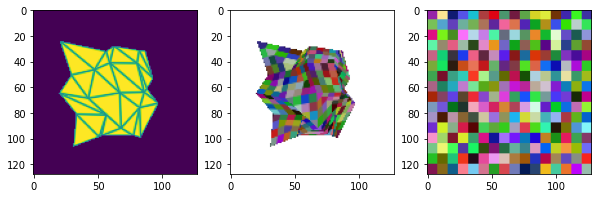

In [41]:
image_size = 128

distance = 3   # distance from camera to the object
elevation = 0.0   # angle of elevation in degrees
azimuth = 150.0  # No rotation so the camera is positioned on the +Z axis. 
R, T = look_at_view_transform(distance, elevation, azimuth, device=device)
cameras = OpenGLPerspectiveCameras(device=device, R=R, T=T)
blend_params = BlendParams(sigma=1e-4, gamma=1e-4)
raster_settings = RasterizationSettings(
    image_size=image_size, 
    blur_radius=0.0, #np.log(1. / 1e-4 - 1.) * blend_params.sigma, 
    faces_per_pixel=1, 
)
lights = PointLights(device=device, location=((2.0, 2.0, -2.0),))
a_diffuse = 0.0
a_ambient = 0.8
s = torch.from_numpy(np.zeros((1, 3)).astype(np.float32)).to(device)
d = torch.from_numpy(np.ones((1, 3)).astype(np.float32)*a_diffuse).to(device)
a = torch.from_numpy(np.ones((1, 3)).astype(np.float32)*a_ambient).to(device)
lights.specular_color = s
lights.diffuse_color = d
lights.ambient_color = a
silhouette_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(cameras=cameras, raster_settings=raster_settings),
    shader=SoftSilhouetteShader(blend_params=blend_params)
)
texture_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(cameras=cameras,raster_settings=raster_settings),
    shader=TexturedSoftPhongShader(device=device, blend_params=blend_params, lights=lights)
#     shader=SoftPhongShader(device=device, cameras=cameras, lights=lights, blend_params=blend_params)
)

# in_dir = './1_data/cow_mesh'
in_dir = './2_data'
s = 16
texturemap_shape = (s, s, 1)
np.random.seed(image_size * s)
texturemap_np = np.random.rand(texturemap_shape[0], texturemap_shape[1], 3)
# texturemap_np = Image.open('./1_data/cow_mesh' + '/cow_texture.png')
# texturemap_np = texturemap_np.convert('RGB')
texturemap_np = np.asarray(texturemap_np).astype(np.float32)
texturemap_np = cv2.resize(texturemap_np, (raster_settings.image_size, raster_settings.image_size), interpolation=cv2.INTER_NEAREST)
texturemap_np = np.expand_dims(texturemap_np, axis=0)
# texturemap_np /= 255.0
texture_map_torch = torch.from_numpy(texturemap_np).to(device)
texture_map = nn.Parameter(texture_map_torch, requires_grad=False)

# mesh_paths = in_dir + '/cube.obj'
mesh_paths = in_dir + '/plane.obj'
# mesh_paths = in_dir + '/cow.obj'
verts, faces, aux = load_obj(mesh_paths)
faces_idx = faces.verts_idx

# Initialize each vertex to be white in color.
verts_uvs = aux.verts_uvs[None, ...].to(device)  # (1, V, 2)
faces_uvs = faces.textures_idx[None, ...].to(device)  # (1, F, 3)
verts_rgb = torch.ones_like(verts)[None]  # (1, V, 3)
textures = Textures(maps=texture_map, faces_uvs=faces_uvs, verts_uvs=verts_uvs, verts_rgb=verts_rgb.to(device)).to(device)

# Create a Meshes object for the teapot. Here we have only one mesh in the batch.
mesh = Meshes(
    verts=[verts.to(device)],   
    faces=[faces_idx.to(device)], 
    textures=textures
)

# deform mesh
scale = 0.5
target_vertex = -1
np.random.seed(int(scale*123))
verts = mesh.verts_packed().detach().cpu().numpy()
dverts_target = (np.random.rand(verts.shape[0], 3).astype(np.float32) - 0.5)*scale
dverts_target = dverts_target.astype(np.float32)
# dverts_target = np.zeros((verts.shape[0], 3)).astype(np.float32)
# dverts_target = dverts_target + np.array([0.2, 0.2, 0.2]).astype(np.float32)
print('dverts: {}, min={:.2f}, max={:.2f}'.format(dverts_target.shape, np.min(dverts_target), np.max(dverts_target)))
dverts_target = torch.from_numpy(dverts_target).to(device)
mesh_target = mesh.clone()
mesh_target = mesh_target.offset_verts(dverts_target)

silhouette = silhouette_renderer(meshes_world=mesh_target)
# image_rendered, prob = texture_renderer(meshes_world=mesh_target)#
image_rendered = texture_renderer(meshes_world=mesh_target)

silhouette = silhouette.cpu().numpy().squeeze()
image_rendered = image_rendered.detach().cpu().numpy().squeeze()

fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(silhouette[..., 3])
ax[1].imshow(image_rendered[..., :3])
mesh_texturemaps = mesh_target.textures._maps_padded.detach().squeeze().cpu().numpy()
ax[2].imshow(mesh_texturemaps, vmin=0, vmax=255)
plt.show()

  0/1000000[dt=0.18s, l=0.268]  100/1000000[dt=7.96s, l=0.281]  200/1000000[dt=7.92s, l=0.273]  300/1000000[dt=7.77s, l=0.278]  400/1000000[dt=7.78s, l=0.270]  500/1000000[dt=7.76s, l=0.247]

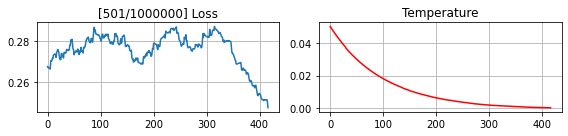


accepted: 417
{'total': 34270621696, 'available': 23166087168, 'percent': 32.4, 'used': 11104534528, 'free': 23166087168}
  600/1000000[dt=8.08s, l=0.233]  700/1000000[dt=7.89s, l=0.202]  800/1000000[dt=7.77s, l=0.193]  900/1000000[dt=8.11s, l=0.175]  1000/1000000[dt=7.88s, l=0.167]

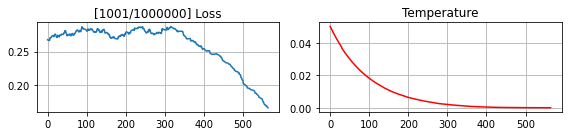


accepted: 565
{'total': 34270621696, 'available': 23151902720, 'percent': 32.4, 'used': 11118718976, 'free': 23151902720}
  1100/1000000[dt=7.98s, l=0.163]  1200/1000000[dt=7.69s, l=0.155]  1300/1000000[dt=7.74s, l=0.152]  1400/1000000[dt=7.65s, l=0.150]  1500/1000000[dt=7.84s, l=0.150]

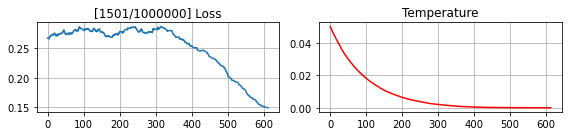


accepted: 613
{'total': 34270621696, 'available': 23153213440, 'percent': 32.4, 'used': 11117408256, 'free': 23153213440}
  1600/1000000[dt=8.04s, l=0.148]  1700/1000000[dt=7.90s, l=0.144]  1800/1000000[dt=8.18s, l=0.142]  1900/1000000[dt=7.74s, l=0.142]  2000/1000000[dt=7.90s, l=0.141]

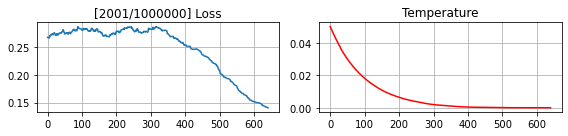


accepted: 641
{'total': 34270621696, 'available': 23158222848, 'percent': 32.4, 'used': 11112398848, 'free': 23158222848}
  2100/1000000[dt=7.94s, l=0.140]  2200/1000000[dt=7.64s, l=0.138]  2300/1000000[dt=8.03s, l=0.137]  2400/1000000[dt=7.84s, l=0.136]  2500/1000000[dt=7.75s, l=0.136]

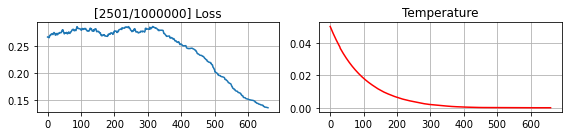


accepted: 661
{'total': 34270621696, 'available': 23152553984, 'percent': 32.4, 'used': 11118067712, 'free': 23152553984}
  2600/1000000[dt=7.87s, l=0.135]  2700/1000000[dt=7.92s, l=0.133]  2800/1000000[dt=7.57s, l=0.133]  2900/1000000[dt=7.93s, l=0.132]  3000/1000000[dt=7.82s, l=0.131]

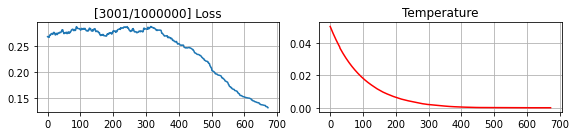


accepted: 673
{'total': 34270621696, 'available': 23127289856, 'percent': 32.5, 'used': 11143331840, 'free': 23127289856}
  3100/1000000[dt=8.07s, l=0.130]  3200/1000000[dt=8.15s, l=0.130]  3300/1000000[dt=7.84s, l=0.129]  3400/1000000[dt=7.82s, l=0.129]  3500/1000000[dt=7.81s, l=0.129]

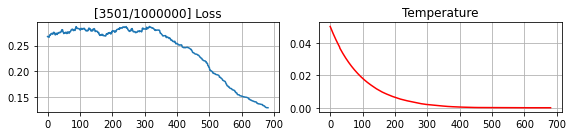


accepted: 682
{'total': 34270621696, 'available': 23111028736, 'percent': 32.6, 'used': 11159592960, 'free': 23111028736}
  3600/1000000[dt=8.06s, l=0.128]  3700/1000000[dt=7.78s, l=0.128]  3800/1000000[dt=7.71s, l=0.128]  3900/1000000[dt=7.83s, l=0.127]  4000/1000000[dt=7.69s, l=0.127]

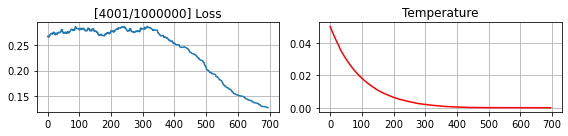


accepted: 696
{'total': 34270621696, 'available': 23104749568, 'percent': 32.6, 'used': 11165872128, 'free': 23104749568}
  4100/1000000[dt=7.93s, l=0.126]  4200/1000000[dt=7.79s, l=0.126]  4300/1000000[dt=7.70s, l=0.126]  4400/1000000[dt=7.87s, l=0.126]  4500/1000000[dt=8.13s, l=0.125]

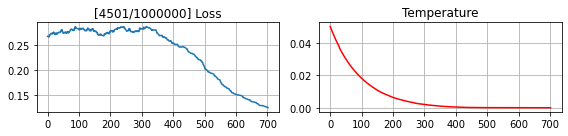


accepted: 703
{'total': 34270621696, 'available': 23105462272, 'percent': 32.6, 'used': 11165159424, 'free': 23105462272}
  4600/1000000[dt=7.98s, l=0.125]  4700/1000000[dt=7.75s, l=0.124]  4800/1000000[dt=7.66s, l=0.124]  4900/1000000[dt=7.93s, l=0.124]  5000/1000000[dt=7.82s, l=0.124]

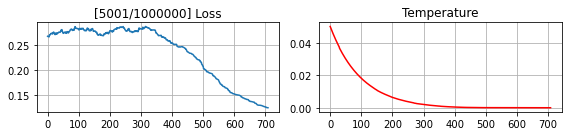


accepted: 709
{'total': 34270621696, 'available': 23119814656, 'percent': 32.5, 'used': 11150807040, 'free': 23119814656}
  5100/1000000[dt=7.95s, l=0.124]  5200/1000000[dt=7.80s, l=0.124]  5300/1000000[dt=7.78s, l=0.124]  5400/1000000[dt=7.91s, l=0.124]  5500/1000000[dt=7.72s, l=0.123]

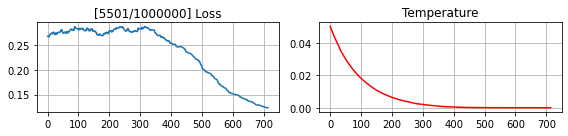


accepted: 715
{'total': 34270621696, 'available': 23114133504, 'percent': 32.6, 'used': 11156488192, 'free': 23114133504}
  5600/1000000[dt=8.04s, l=0.123]  5700/1000000[dt=7.72s, l=0.123]  5800/1000000[dt=7.84s, l=0.123]  5900/1000000[dt=7.77s, l=0.123]  6000/1000000[dt=8.08s, l=0.123]

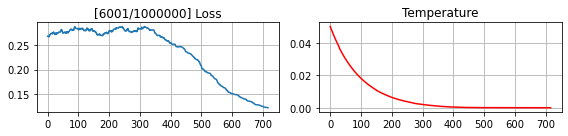


accepted: 717
{'total': 34270621696, 'available': 23115329536, 'percent': 32.6, 'used': 11155292160, 'free': 23115329536}
  6100/1000000[dt=8.07s, l=0.123]  6200/1000000[dt=7.77s, l=0.123]  6300/1000000[dt=7.90s, l=0.123]  6400/1000000[dt=7.88s, l=0.122]  6500/1000000[dt=8.02s, l=0.122]

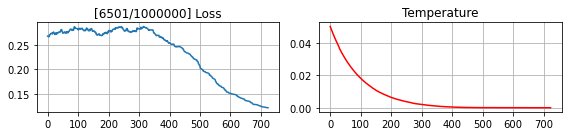


accepted: 724
{'total': 34270621696, 'available': 23141277696, 'percent': 32.5, 'used': 11129344000, 'free': 23141277696}
  6600/1000000[dt=7.89s, l=0.122]  6700/1000000[dt=7.86s, l=0.122]  6800/1000000[dt=7.92s, l=0.122]  6900/1000000[dt=7.99s, l=0.122]  7000/1000000[dt=7.77s, l=0.122]

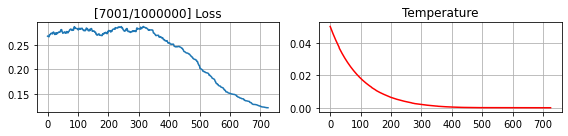


accepted: 726
{'total': 34270621696, 'available': 23117615104, 'percent': 32.5, 'used': 11153006592, 'free': 23117615104}
  7100/1000000[dt=7.88s, l=0.122]  7200/1000000[dt=7.86s, l=0.122]  7300/1000000[dt=7.74s, l=0.122]  7400/1000000[dt=7.79s, l=0.122]  7500/1000000[dt=7.76s, l=0.122]

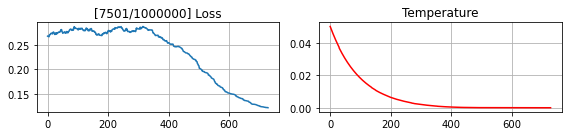


accepted: 729
{'total': 34270621696, 'available': 23123832832, 'percent': 32.5, 'used': 11146788864, 'free': 23123832832}
  7600/1000000[dt=7.89s, l=0.122]  7700/1000000[dt=7.88s, l=0.122]  7800/1000000[dt=7.93s, l=0.122]  7900/1000000[dt=7.70s, l=0.122]  8000/1000000[dt=7.80s, l=0.122]

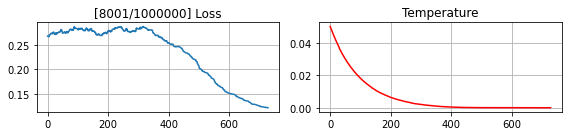


accepted: 729
{'total': 34270621696, 'available': 23142514688, 'percent': 32.5, 'used': 11128107008, 'free': 23142514688}
  8100/1000000[dt=7.82s, l=0.122]  8200/1000000[dt=7.68s, l=0.121]  8300/1000000[dt=7.68s, l=0.121]  8400/1000000[dt=7.71s, l=0.120]  8500/1000000[dt=7.86s, l=0.120]

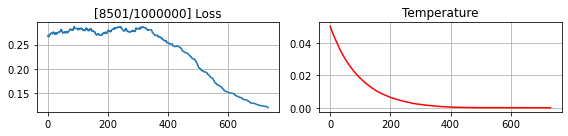


accepted: 733
{'total': 34270621696, 'available': 23147823104, 'percent': 32.5, 'used': 11122798592, 'free': 23147823104}
  8600/1000000[dt=7.89s, l=0.120]  8700/1000000[dt=7.72s, l=0.119]  8800/1000000[dt=7.75s, l=0.119]  8900/1000000[dt=7.70s, l=0.119]  9000/1000000[dt=7.79s, l=0.119]

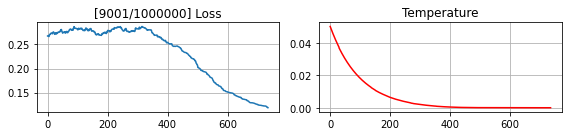


accepted: 736
{'total': 34270621696, 'available': 23127019520, 'percent': 32.5, 'used': 11143602176, 'free': 23127019520}
  9100/1000000[dt=7.83s, l=0.119]  9200/1000000[dt=7.69s, l=0.119]  9300/1000000[dt=7.70s, l=0.119]  9400/1000000[dt=7.76s, l=0.119]  9500/1000000[dt=7.70s, l=0.119]

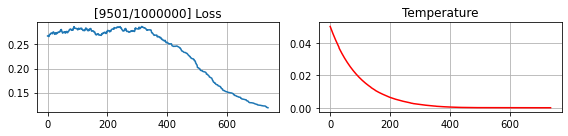


accepted: 738
{'total': 34270621696, 'available': 23120920576, 'percent': 32.5, 'used': 11149701120, 'free': 23120920576}
  9600/1000000[dt=7.94s, l=0.119]  9700/1000000[dt=8.01s, l=0.119]  9800/1000000[dt=7.93s, l=0.119]  9900/1000000[dt=8.09s, l=0.118]  10000/1000000[dt=7.61s, l=0.118]

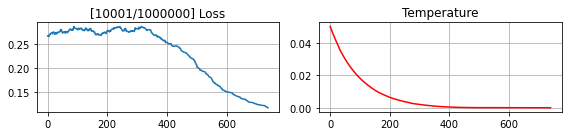


accepted: 740
{'total': 34270621696, 'available': 23117402112, 'percent': 32.5, 'used': 11153219584, 'free': 23117402112}
  10100/1000000[dt=7.77s, l=0.118]  10200/1000000[dt=7.64s, l=0.118]  10300/1000000[dt=7.74s, l=0.118]  10400/1000000[dt=8.19s, l=0.118]  10500/1000000[dt=7.77s, l=0.118]

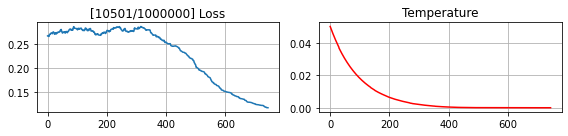


accepted: 745
{'total': 34270621696, 'available': 23136911360, 'percent': 32.5, 'used': 11133710336, 'free': 23136911360}
  10600/1000000[dt=8.00s, l=0.117]  10700/1000000[dt=8.16s, l=0.117]  10800/1000000[dt=7.75s, l=0.117]  10900/1000000[dt=7.76s, l=0.117]  11000/1000000[dt=7.93s, l=0.117]

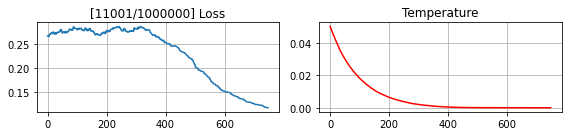


accepted: 748
{'total': 34270621696, 'available': 23113768960, 'percent': 32.6, 'used': 11156852736, 'free': 23113768960}
  11100/1000000[dt=8.33s, l=0.117]  11200/1000000[dt=7.65s, l=0.117]  11300/1000000[dt=7.82s, l=0.117]  11400/1000000[dt=7.69s, l=0.117]  11500/1000000[dt=7.67s, l=0.117]

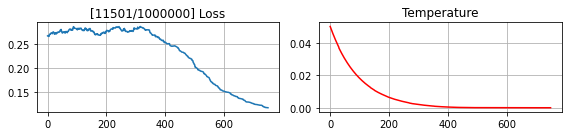


accepted: 750
{'total': 34270621696, 'available': 23113285632, 'percent': 32.6, 'used': 11157336064, 'free': 23113285632}
  11600/1000000[dt=8.00s, l=0.117]  11700/1000000[dt=7.70s, l=0.117]  11800/1000000[dt=7.66s, l=0.117]  11900/1000000[dt=7.89s, l=0.117]  12000/1000000[dt=8.06s, l=0.117]

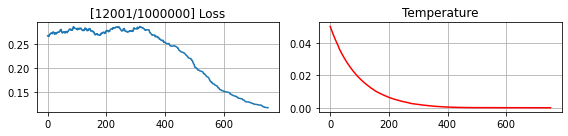


accepted: 752
{'total': 34270621696, 'available': 23118327808, 'percent': 32.5, 'used': 11152293888, 'free': 23118327808}
  12100/1000000[dt=7.81s, l=0.117]  12200/1000000[dt=7.68s, l=0.117]  12300/1000000[dt=7.70s, l=0.117]  12400/1000000[dt=7.90s, l=0.117]  12500/1000000[dt=7.79s, l=0.117]

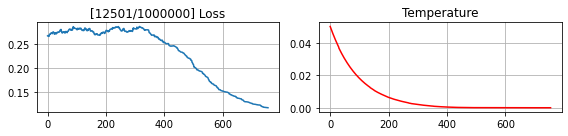


accepted: 756
{'total': 34270621696, 'available': 23156076544, 'percent': 32.4, 'used': 11114545152, 'free': 23156076544}
  12600/1000000[dt=7.92s, l=0.117]  12700/1000000[dt=7.67s, l=0.117]  12800/1000000[dt=7.68s, l=0.117]  12900/1000000[dt=8.01s, l=0.117]  13000/1000000[dt=7.69s, l=0.117]

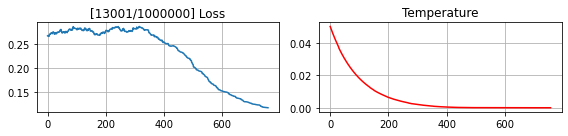


accepted: 758
{'total': 34270621696, 'available': 23150317568, 'percent': 32.4, 'used': 11120304128, 'free': 23150317568}
  13100/1000000[dt=7.78s, l=0.117]  13200/1000000[dt=7.63s, l=0.117]  13300/1000000[dt=7.78s, l=0.116]  13400/1000000[dt=7.76s, l=0.116]  13500/1000000[dt=7.91s, l=0.116]

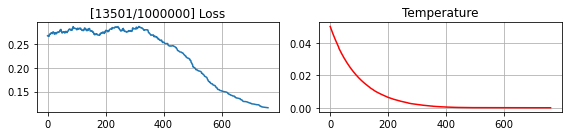


accepted: 761
{'total': 34270621696, 'available': 23137251328, 'percent': 32.5, 'used': 11133370368, 'free': 23137251328}
  13600/1000000[dt=8.18s, l=0.116]  13700/1000000[dt=7.92s, l=0.116]  13800/1000000[dt=7.66s, l=0.116]  13900/1000000[dt=8.05s, l=0.116]  14000/1000000[dt=7.76s, l=0.116]

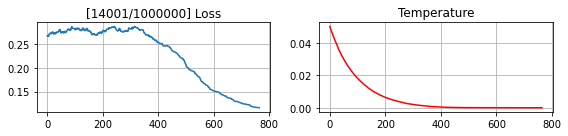


accepted: 765
{'total': 34270621696, 'available': 23133360128, 'percent': 32.5, 'used': 11137261568, 'free': 23133360128}
  14100/1000000[dt=8.41s, l=0.116]  14200/1000000[dt=7.97s, l=0.116]  14300/1000000[dt=7.92s, l=0.116]  14400/1000000[dt=7.94s, l=0.116]  14500/1000000[dt=8.12s, l=0.116]

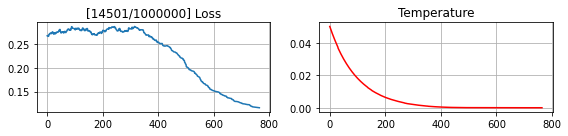


accepted: 765
{'total': 34270621696, 'available': 23116939264, 'percent': 32.5, 'used': 11153682432, 'free': 23116939264}
  14600/1000000[dt=8.26s, l=0.116]  14700/1000000[dt=7.97s, l=0.116]  14800/1000000[dt=7.87s, l=0.116]  14900/1000000[dt=7.92s, l=0.115]  15000/1000000[dt=8.17s, l=0.115]

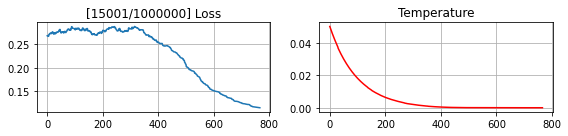


accepted: 767
{'total': 34270621696, 'available': 23111430144, 'percent': 32.6, 'used': 11159191552, 'free': 23111430144}
  15100/1000000[dt=8.28s, l=0.115]  15200/1000000[dt=8.30s, l=0.115]  15300/1000000[dt=8.23s, l=0.115]  15400/1000000[dt=7.88s, l=0.115]  15500/1000000[dt=7.95s, l=0.115]

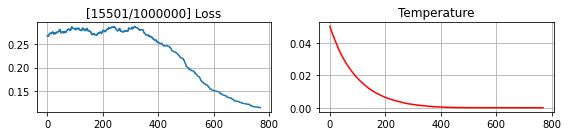


accepted: 769
{'total': 34270621696, 'available': 23101394944, 'percent': 32.6, 'used': 11169226752, 'free': 23101394944}
  15600/1000000[dt=8.33s, l=0.115]  15700/1000000[dt=8.17s, l=0.115]  15800/1000000[dt=7.94s, l=0.115]  15900/1000000[dt=7.84s, l=0.115]  16000/1000000[dt=7.60s, l=0.115]

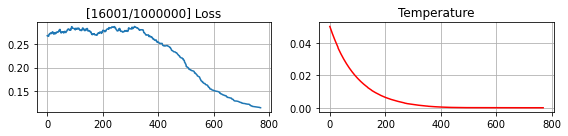


accepted: 770
{'total': 34270621696, 'available': 23057080320, 'percent': 32.7, 'used': 11213541376, 'free': 23057080320}
  16100/1000000[dt=8.12s, l=0.115]  16200/1000000[dt=7.62s, l=0.115]  16300/1000000[dt=7.74s, l=0.115]  16400/1000000[dt=7.67s, l=0.115]  16500/1000000[dt=7.70s, l=0.115]

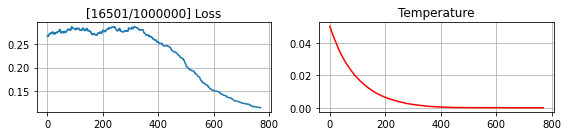


accepted: 770
{'total': 34270621696, 'available': 23059439616, 'percent': 32.7, 'used': 11211182080, 'free': 23059439616}
  16600/1000000[dt=8.38s, l=0.115]  16700/1000000[dt=8.18s, l=0.115]  16800/1000000[dt=7.77s, l=0.115]  16900/1000000[dt=7.67s, l=0.115]  17000/1000000[dt=7.97s, l=0.115]

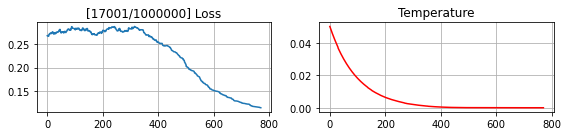


accepted: 771
{'total': 34270621696, 'available': 23066374144, 'percent': 32.7, 'used': 11204247552, 'free': 23066374144}
  17100/1000000[dt=8.36s, l=0.115]  17200/1000000[dt=7.69s, l=0.115]  17300/1000000[dt=7.71s, l=0.115]  17400/1000000[dt=7.81s, l=0.115]  17500/1000000[dt=7.70s, l=0.115]

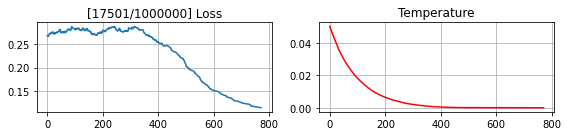


accepted: 772
{'total': 34270621696, 'available': 23040143360, 'percent': 32.8, 'used': 11230478336, 'free': 23040143360}
  17600/1000000[dt=7.94s, l=0.115]  17700/1000000[dt=7.75s, l=0.115]  17800/1000000[dt=7.70s, l=0.115]  17900/1000000[dt=7.76s, l=0.115]  18000/1000000[dt=7.96s, l=0.115]

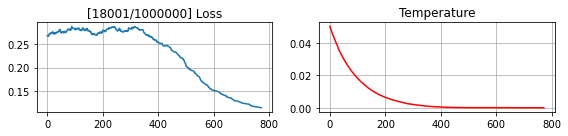


accepted: 773
{'total': 34270621696, 'available': 23048278016, 'percent': 32.7, 'used': 11222343680, 'free': 23048278016}
  18100/1000000[dt=7.87s, l=0.115]  18200/1000000[dt=7.83s, l=0.115]  18300/1000000[dt=7.62s, l=0.115]  18400/1000000[dt=7.91s, l=0.115]  18500/1000000[dt=7.70s, l=0.115]

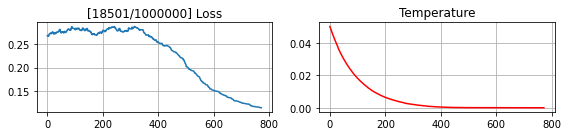


accepted: 773
{'total': 34270621696, 'available': 23063138304, 'percent': 32.7, 'used': 11207483392, 'free': 23063138304}
  18600/1000000[dt=7.77s, l=0.115]  18700/1000000[dt=7.64s, l=0.115]  18800/1000000[dt=7.83s, l=0.115]  18900/1000000[dt=7.66s, l=0.115]  19000/1000000[dt=7.74s, l=0.115]

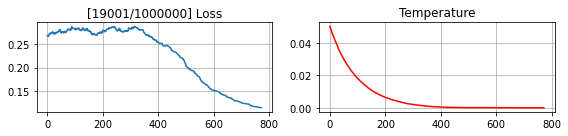


accepted: 773
{'total': 34270621696, 'available': 23019122688, 'percent': 32.8, 'used': 11251499008, 'free': 23019122688}
  19100/1000000[dt=7.82s, l=0.115]  19200/1000000[dt=7.81s, l=0.115]  19300/1000000[dt=7.60s, l=0.115]  19400/1000000[dt=7.62s, l=0.115]  19500/1000000[dt=7.69s, l=0.115]

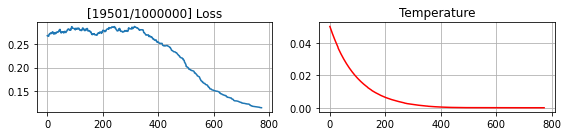


accepted: 774
{'total': 34270621696, 'available': 23029518336, 'percent': 32.8, 'used': 11241103360, 'free': 23029518336}
  19600/1000000[dt=8.01s, l=0.114]  19700/1000000[dt=7.85s, l=0.114]  19800/1000000[dt=7.66s, l=0.114]  19900/1000000[dt=7.70s, l=0.114]  20000/1000000[dt=7.60s, l=0.114]

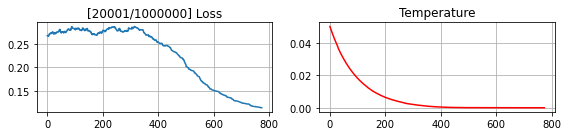


accepted: 775
{'total': 34270621696, 'available': 23041134592, 'percent': 32.8, 'used': 11229487104, 'free': 23041134592}
  20100/1000000[dt=8.17s, l=0.114]  20200/1000000[dt=7.86s, l=0.114]  20300/1000000[dt=7.62s, l=0.114]  20400/1000000[dt=8.00s, l=0.114]  20500/1000000[dt=7.61s, l=0.114]

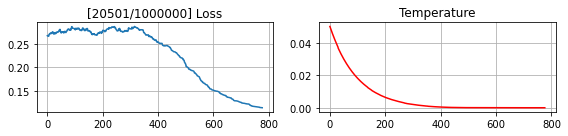


accepted: 777
{'total': 34270621696, 'available': 23060598784, 'percent': 32.7, 'used': 11210022912, 'free': 23060598784}
  20600/1000000[dt=7.87s, l=0.114]  20700/1000000[dt=7.75s, l=0.114]  20800/1000000[dt=7.81s, l=0.114]  20900/1000000[dt=7.70s, l=0.114]  21000/1000000[dt=7.89s, l=0.114]

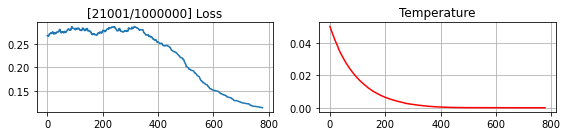


accepted: 778
{'total': 34270621696, 'available': 23021735936, 'percent': 32.8, 'used': 11248885760, 'free': 23021735936}
  21100/1000000[dt=8.46s, l=0.114]  21200/1000000[dt=7.91s, l=0.114]  21300/1000000[dt=7.78s, l=0.114]  21400/1000000[dt=8.04s, l=0.114]  21500/1000000[dt=8.13s, l=0.114]

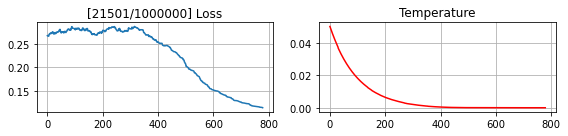


accepted: 779
{'total': 34270621696, 'available': 22778826752, 'percent': 33.5, 'used': 11491794944, 'free': 22778826752}
  21600/1000000[dt=8.81s, l=0.114]  21700/1000000[dt=8.38s, l=0.114]  21800/1000000[dt=8.57s, l=0.114]  21900/1000000[dt=8.55s, l=0.114]  22000/1000000[dt=8.23s, l=0.114]

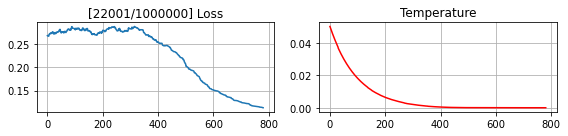


accepted: 781
{'total': 34270621696, 'available': 22997045248, 'percent': 32.9, 'used': 11273576448, 'free': 22997045248}
  22100/1000000[dt=8.26s, l=0.114]  22200/1000000[dt=8.10s, l=0.114]  22300/1000000[dt=8.15s, l=0.114]  22400/1000000[dt=7.94s, l=0.114]  22500/1000000[dt=7.56s, l=0.114]

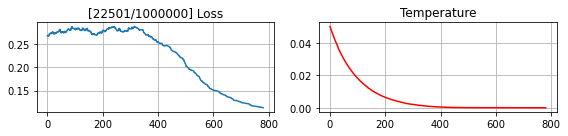


accepted: 781
{'total': 34270621696, 'available': 23159140352, 'percent': 32.4, 'used': 11111481344, 'free': 23159140352}
  22600/1000000[dt=7.85s, l=0.114]  22700/1000000[dt=7.96s, l=0.114]  22800/1000000[dt=8.07s, l=0.114]  22900/1000000[dt=7.72s, l=0.114]  23000/1000000[dt=7.68s, l=0.114]

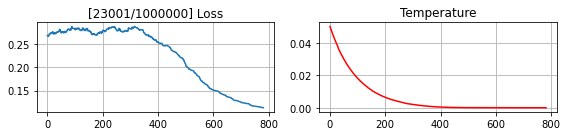


accepted: 782
{'total': 34270621696, 'available': 23177404416, 'percent': 32.4, 'used': 11093217280, 'free': 23177404416}
  23100/1000000[dt=7.98s, l=0.114]  23200/1000000[dt=7.83s, l=0.114]  23300/1000000[dt=7.86s, l=0.114]  23400/1000000[dt=7.97s, l=0.114]  23500/1000000[dt=7.99s, l=0.114]

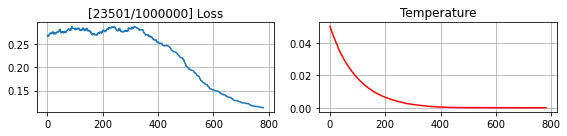


accepted: 782
{'total': 34270621696, 'available': 23141568512, 'percent': 32.5, 'used': 11129053184, 'free': 23141568512}
  23600/1000000[dt=7.98s, l=0.114]  23700/1000000[dt=7.68s, l=0.114]  23800/1000000[dt=7.64s, l=0.114]  23900/1000000[dt=8.05s, l=0.114]  24000/1000000[dt=7.69s, l=0.114]

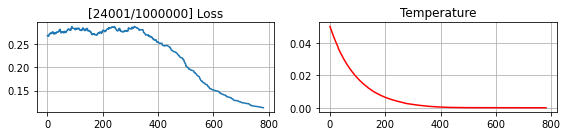


accepted: 782
{'total': 34270621696, 'available': 23138615296, 'percent': 32.5, 'used': 11132006400, 'free': 23138615296}
  24100/1000000[dt=8.01s, l=0.114]  24200/1000000[dt=7.57s, l=0.114]  24300/1000000[dt=7.69s, l=0.114]  24400/1000000[dt=7.70s, l=0.114]  24500/1000000[dt=7.81s, l=0.114]

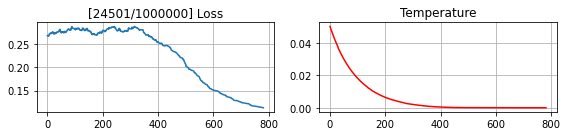


accepted: 782
{'total': 34270621696, 'available': 23137292288, 'percent': 32.5, 'used': 11133329408, 'free': 23137292288}
  24600/1000000[dt=7.78s, l=0.114]  24700/1000000[dt=7.82s, l=0.114]  24800/1000000[dt=7.70s, l=0.114]  24900/1000000[dt=7.69s, l=0.114]  25000/1000000[dt=7.85s, l=0.113]

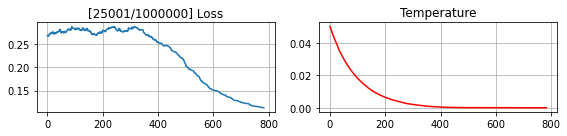


accepted: 784
{'total': 34270621696, 'available': 23169904640, 'percent': 32.4, 'used': 11100717056, 'free': 23169904640}
  25100/1000000[dt=8.07s, l=0.113]  25200/1000000[dt=7.69s, l=0.113]  25300/1000000[dt=7.85s, l=0.113]  25400/1000000[dt=7.67s, l=0.113]  25500/1000000[dt=7.75s, l=0.113]

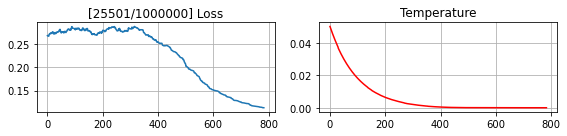


accepted: 784
{'total': 34270621696, 'available': 23171031040, 'percent': 32.4, 'used': 11099590656, 'free': 23171031040}
  25600/1000000[dt=7.82s, l=0.113]  25700/1000000[dt=7.83s, l=0.113]  25800/1000000[dt=7.79s, l=0.113]  25900/1000000[dt=7.63s, l=0.113]  26000/1000000[dt=7.75s, l=0.113]

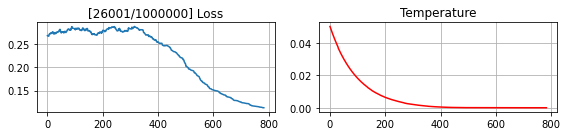


accepted: 784
{'total': 34270621696, 'available': 23156989952, 'percent': 32.4, 'used': 11113631744, 'free': 23156989952}
  26100/1000000[dt=7.99s, l=0.113]  26200/1000000[dt=8.27s, l=0.113]  26300/1000000[dt=7.99s, l=0.113]  26400/1000000[dt=7.64s, l=0.113]  26500/1000000[dt=7.66s, l=0.113]

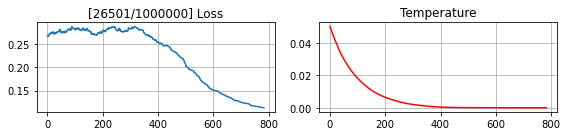


accepted: 784
{'total': 34270621696, 'available': 23120310272, 'percent': 32.5, 'used': 11150311424, 'free': 23120310272}
  26600/1000000[dt=8.04s, l=0.113]  26700/1000000[dt=8.05s, l=0.113]  26800/1000000[dt=7.98s, l=0.113]  26900/1000000[dt=7.70s, l=0.113]  27000/1000000[dt=7.91s, l=0.113]

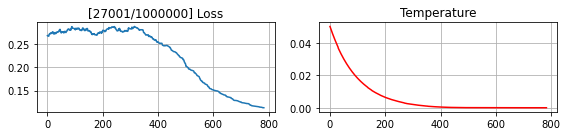


accepted: 784
{'total': 34270621696, 'available': 23123673088, 'percent': 32.5, 'used': 11146948608, 'free': 23123673088}
  27100/1000000[dt=8.37s, l=0.113]  27200/1000000[dt=8.17s, l=0.113]  27300/1000000[dt=7.93s, l=0.113]  27400/1000000[dt=7.84s, l=0.113]  27500/1000000[dt=7.64s, l=0.113]

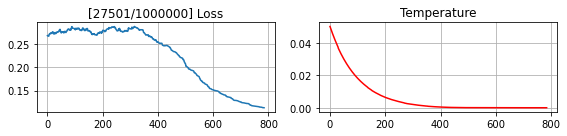


accepted: 785
{'total': 34270621696, 'available': 23113789440, 'percent': 32.6, 'used': 11156832256, 'free': 23113789440}
  27600/1000000[dt=7.83s, l=0.113]  27700/1000000[dt=7.70s, l=0.113]  27800/1000000[dt=7.68s, l=0.113]  27900/1000000[dt=7.84s, l=0.113]  28000/1000000[dt=7.78s, l=0.113]

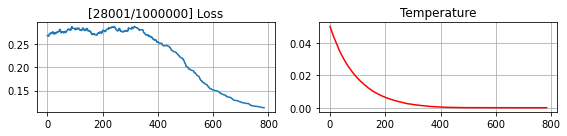


accepted: 785
{'total': 34270621696, 'available': 23149133824, 'percent': 32.5, 'used': 11121487872, 'free': 23149133824}
  28100/1000000[dt=7.97s, l=0.113]  28200/1000000[dt=7.74s, l=0.113]  28300/1000000[dt=7.68s, l=0.113]  28400/1000000[dt=7.67s, l=0.113]  28500/1000000[dt=7.93s, l=0.113]

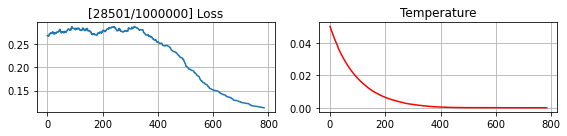


accepted: 785
{'total': 34270621696, 'available': 23133290496, 'percent': 32.5, 'used': 11137331200, 'free': 23133290496}
  28600/1000000[dt=8.11s, l=0.113]  28700/1000000[dt=7.85s, l=0.113]  28800/1000000[dt=7.54s, l=0.113]  28900/1000000[dt=7.63s, l=0.113]  29000/1000000[dt=7.60s, l=0.113]

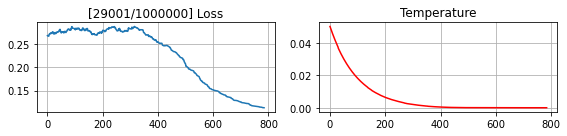


accepted: 785
{'total': 34270621696, 'available': 23116857344, 'percent': 32.5, 'used': 11153764352, 'free': 23116857344}
  29100/1000000[dt=7.80s, l=0.113]  29200/1000000[dt=7.64s, l=0.113]  29300/1000000[dt=7.78s, l=0.113]  29400/1000000[dt=7.65s, l=0.113]  29500/1000000[dt=7.72s, l=0.113]

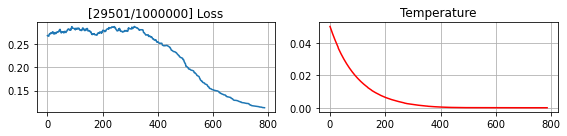


accepted: 787
{'total': 34270621696, 'available': 23114977280, 'percent': 32.6, 'used': 11155644416, 'free': 23114977280}
  29600/1000000[dt=7.79s, l=0.113]  29700/1000000[dt=8.01s, l=0.113]  29800/1000000[dt=7.75s, l=0.113]  29900/1000000[dt=7.67s, l=0.113]  30000/1000000[dt=7.93s, l=0.113]

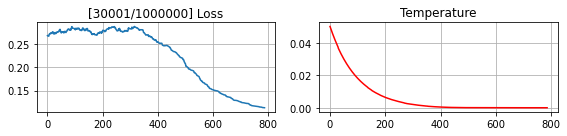


accepted: 787
{'total': 34270621696, 'available': 23115808768, 'percent': 32.5, 'used': 11154812928, 'free': 23115808768}
  30100/1000000[dt=8.01s, l=0.113]  30200/1000000[dt=7.74s, l=0.113]  30300/1000000[dt=7.87s, l=0.113]  30400/1000000[dt=8.06s, l=0.113]  30500/1000000[dt=7.80s, l=0.113]

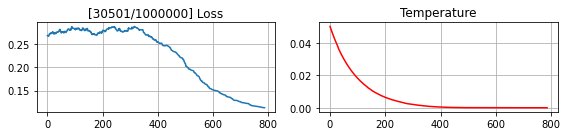


accepted: 787
{'total': 34270621696, 'available': 23017390080, 'percent': 32.8, 'used': 11253231616, 'free': 23017390080}
  30600/1000000[dt=8.20s, l=0.113]  30700/1000000[dt=7.75s, l=0.113]  30800/1000000[dt=7.90s, l=0.113]  30900/1000000[dt=7.71s, l=0.113]  31000/1000000[dt=7.85s, l=0.113]

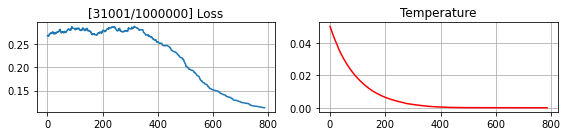


accepted: 787
{'total': 34270621696, 'available': 23014080512, 'percent': 32.8, 'used': 11256541184, 'free': 23014080512}
  31100/1000000[dt=8.10s, l=0.113]  31200/1000000[dt=7.92s, l=0.113]  31300/1000000[dt=7.74s, l=0.113]  31400/1000000[dt=8.07s, l=0.113]  31500/1000000[dt=8.08s, l=0.113]

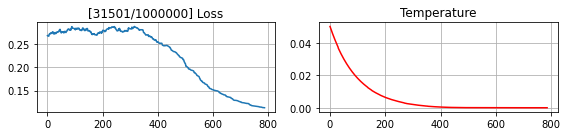


accepted: 787
{'total': 34270621696, 'available': 23225819136, 'percent': 32.2, 'used': 11044802560, 'free': 23225819136}
  31600/1000000[dt=7.81s, l=0.113]  31700/1000000[dt=7.62s, l=0.113]  31800/1000000[dt=7.83s, l=0.113]  31900/1000000[dt=7.85s, l=0.113]  32000/1000000[dt=7.66s, l=0.113]

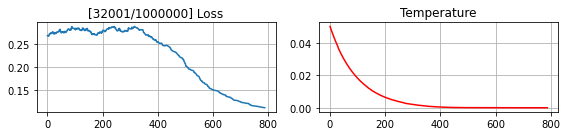


accepted: 788
{'total': 34270621696, 'available': 23247974400, 'percent': 32.2, 'used': 11022647296, 'free': 23247974400}
  32100/1000000[dt=7.73s, l=0.113]  32200/1000000[dt=7.64s, l=0.113]  32300/1000000[dt=7.66s, l=0.113]  32400/1000000[dt=7.79s, l=0.113]  32500/1000000[dt=7.81s, l=0.113]

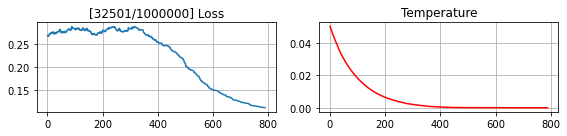


accepted: 789
{'total': 34270621696, 'available': 23247298560, 'percent': 32.2, 'used': 11023323136, 'free': 23247298560}
  32600/1000000[dt=7.77s, l=0.113]  32700/1000000[dt=7.64s, l=0.113]  32800/1000000[dt=7.61s, l=0.113]  32900/1000000[dt=7.95s, l=0.113]  33000/1000000[dt=8.15s, l=0.113]

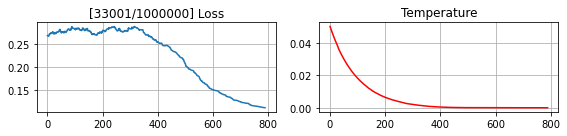


accepted: 789
{'total': 34270621696, 'available': 23196024832, 'percent': 32.3, 'used': 11074596864, 'free': 23196024832}
  33100/1000000[dt=8.47s, l=0.113]  33200/1000000[dt=7.92s, l=0.113]  33300/1000000[dt=8.16s, l=0.113]  33400/1000000[dt=8.46s, l=0.113]  33500/1000000[dt=8.57s, l=0.113]

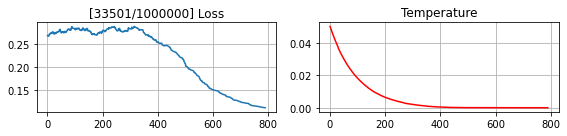


accepted: 790
{'total': 34270621696, 'available': 22989578240, 'percent': 32.9, 'used': 11281043456, 'free': 22989578240}
  33600/1000000[dt=8.59s, l=0.113]  33700/1000000[dt=8.64s, l=0.113]  33800/1000000[dt=8.35s, l=0.113]  33900/1000000[dt=8.13s, l=0.113]  34000/1000000[dt=8.31s, l=0.113]

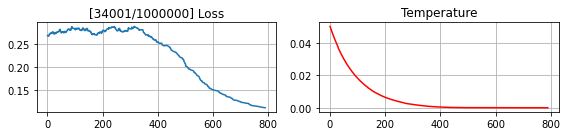


accepted: 790
{'total': 34270621696, 'available': 22949281792, 'percent': 33.0, 'used': 11321339904, 'free': 22949281792}
  34100/1000000[dt=8.34s, l=0.113]  34200/1000000[dt=8.17s, l=0.113]  34300/1000000[dt=8.28s, l=0.113]  34400/1000000[dt=8.12s, l=0.113]  34500/1000000[dt=8.17s, l=0.113]

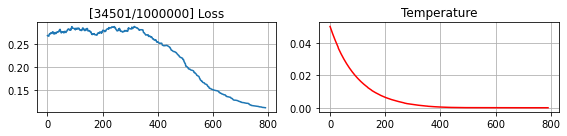


accepted: 791
{'total': 34270621696, 'available': 22983286784, 'percent': 32.9, 'used': 11287334912, 'free': 22983286784}
  34600/1000000[dt=8.31s, l=0.113]  34700/1000000[dt=8.54s, l=0.113]  34800/1000000[dt=8.34s, l=0.113]  34900/1000000[dt=8.18s, l=0.113]  35000/1000000[dt=8.31s, l=0.113]

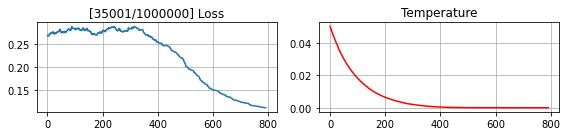


accepted: 792
{'total': 34270621696, 'available': 23277035520, 'percent': 32.1, 'used': 10993586176, 'free': 23277035520}
  35100/1000000[dt=7.92s, l=0.113]  35200/1000000[dt=7.82s, l=0.113]  35300/1000000[dt=8.19s, l=0.113]  35400/1000000[dt=8.49s, l=0.113]  35500/1000000[dt=8.70s, l=0.113]

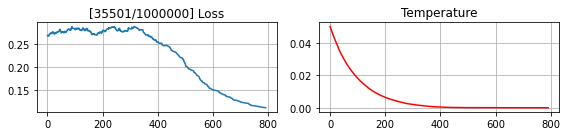


accepted: 792
{'total': 34270621696, 'available': 22719795200, 'percent': 33.7, 'used': 11550826496, 'free': 22719795200}
  35600/1000000[dt=8.86s, l=0.113]  35700/1000000[dt=8.59s, l=0.113]  35800/1000000[dt=8.22s, l=0.113]  35900/1000000[dt=7.92s, l=0.113]  36000/1000000[dt=7.97s, l=0.113]

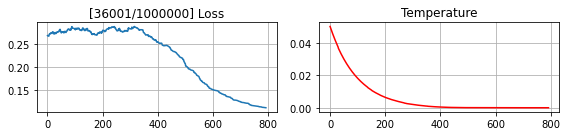


accepted: 793
{'total': 34270621696, 'available': 23284523008, 'percent': 32.1, 'used': 10986098688, 'free': 23284523008}
  36100/1000000[dt=7.96s, l=0.113]  36200/1000000[dt=7.67s, l=0.113]  36300/1000000[dt=7.79s, l=0.113]  36400/1000000[dt=7.94s, l=0.113]  36500/1000000[dt=7.79s, l=0.113]

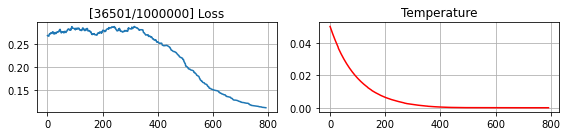


accepted: 793
{'total': 34270621696, 'available': 23293923328, 'percent': 32.0, 'used': 10976698368, 'free': 23293923328}
  36600/1000000[dt=8.09s, l=0.113]  36700/1000000[dt=8.27s, l=0.113]  36800/1000000[dt=7.80s, l=0.113]  36900/1000000[dt=8.24s, l=0.113]  37000/1000000[dt=8.37s, l=0.113]

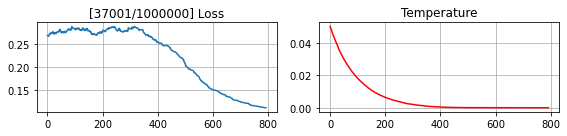


accepted: 793
{'total': 34270621696, 'available': 23172263936, 'percent': 32.4, 'used': 11098357760, 'free': 23172263936}
  37100/1000000[dt=8.26s, l=0.113]  37200/1000000[dt=8.04s, l=0.113]  37300/1000000[dt=7.90s, l=0.113]  37400/1000000[dt=7.76s, l=0.113]  37500/1000000[dt=8.19s, l=0.113]

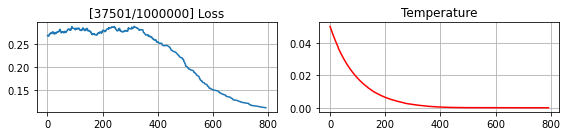


accepted: 793
{'total': 34270621696, 'available': 23165890560, 'percent': 32.4, 'used': 11104731136, 'free': 23165890560}
  37600/1000000[dt=8.08s, l=0.113]  37700/1000000[dt=7.86s, l=0.113]  37800/1000000[dt=8.01s, l=0.113]  37900/1000000[dt=8.24s, l=0.113]  38000/1000000[dt=8.10s, l=0.113]

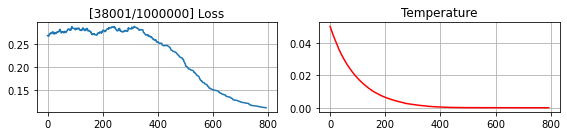


accepted: 794
{'total': 34270621696, 'available': 22295089152, 'percent': 34.9, 'used': 11975532544, 'free': 22295089152}
  38100/1000000[dt=8.08s, l=0.113]  38200/1000000[dt=7.90s, l=0.113]  38300/1000000[dt=7.81s, l=0.113]  38400/1000000[dt=7.71s, l=0.113]  38500/1000000[dt=7.80s, l=0.113]

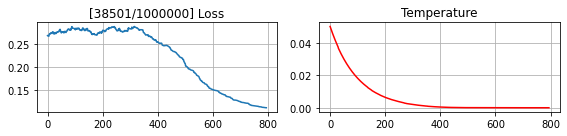


accepted: 795
{'total': 34270621696, 'available': 22313512960, 'percent': 34.9, 'used': 11957108736, 'free': 22313512960}
  38600/1000000[dt=7.91s, l=0.113]  38700/1000000[dt=7.82s, l=0.113]  38800/1000000[dt=7.82s, l=0.113]  38900/1000000[dt=7.81s, l=0.113]  39000/1000000[dt=7.82s, l=0.112]

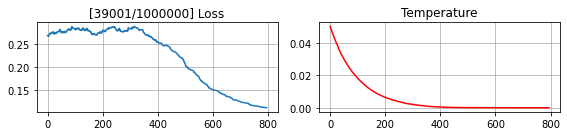


accepted: 796
{'total': 34270621696, 'available': 22325796864, 'percent': 34.9, 'used': 11944824832, 'free': 22325796864}
  39100/1000000[dt=8.17s, l=0.112]  39200/1000000[dt=8.03s, l=0.112]  39300/1000000[dt=7.81s, l=0.112]  39400/1000000[dt=8.06s, l=0.112]  39500/1000000[dt=8.03s, l=0.112]

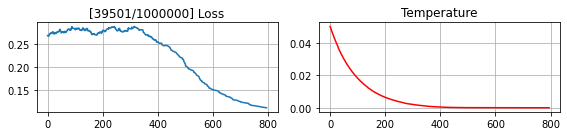


accepted: 796
{'total': 34270621696, 'available': 22312140800, 'percent': 34.9, 'used': 11958480896, 'free': 22312140800}
  39600/1000000[dt=7.90s, l=0.112]  39700/1000000[dt=7.82s, l=0.112]  39800/1000000[dt=7.88s, l=0.112]  39900/1000000[dt=8.15s, l=0.112]  40000/1000000[dt=7.77s, l=0.112]

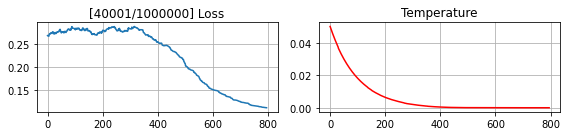


accepted: 796
{'total': 34270621696, 'available': 22298259456, 'percent': 34.9, 'used': 11972362240, 'free': 22298259456}
  40100/1000000[dt=7.88s, l=0.112]  40200/1000000[dt=7.78s, l=0.112]  40300/1000000[dt=7.78s, l=0.112]  40400/1000000[dt=7.87s, l=0.112]  40500/1000000[dt=7.86s, l=0.112]

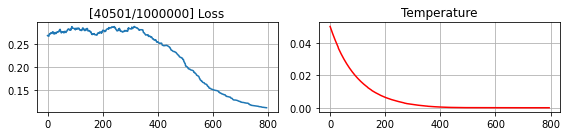


accepted: 796
{'total': 34270621696, 'available': 22305787904, 'percent': 34.9, 'used': 11964833792, 'free': 22305787904}
  40600/1000000[dt=8.07s, l=0.112]  40700/1000000[dt=7.78s, l=0.112]  40800/1000000[dt=7.75s, l=0.112]  40900/1000000[dt=7.86s, l=0.112]  41000/1000000[dt=7.85s, l=0.112]

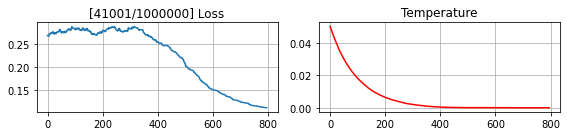


accepted: 796
{'total': 34270621696, 'available': 22322307072, 'percent': 34.9, 'used': 11948314624, 'free': 22322307072}
  41100/1000000[dt=7.96s, l=0.112]  41200/1000000[dt=7.93s, l=0.112]  41300/1000000[dt=7.79s, l=0.112]  41400/1000000[dt=7.92s, l=0.112]  41500/1000000[dt=7.84s, l=0.112]

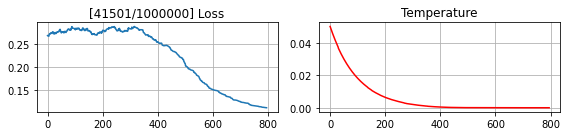


accepted: 796
{'total': 34270621696, 'available': 23252520960, 'percent': 32.2, 'used': 11018100736, 'free': 23252520960}
  41600/1000000[dt=8.04s, l=0.112]  41700/1000000[dt=7.75s, l=0.112]  41800/1000000[dt=7.70s, l=0.112]  41900/1000000[dt=7.69s, l=0.112]  42000/1000000[dt=7.90s, l=0.112]

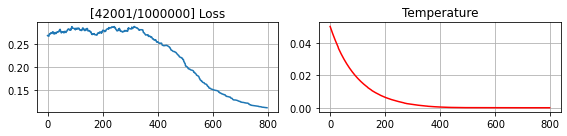


accepted: 798
{'total': 34270621696, 'available': 23242973184, 'percent': 32.2, 'used': 11027648512, 'free': 23242973184}
  42100/1000000[dt=8.00s, l=0.112]  42200/1000000[dt=7.70s, l=0.112]  42300/1000000[dt=7.67s, l=0.112]  42400/1000000[dt=7.82s, l=0.112]  42500/1000000[dt=7.80s, l=0.112]

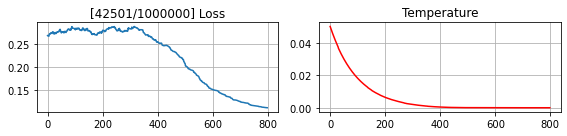


accepted: 799
{'total': 34270621696, 'available': 23264485376, 'percent': 32.1, 'used': 11006136320, 'free': 23264485376}
  42600/1000000[dt=8.03s, l=0.112]  42700/1000000[dt=7.75s, l=0.112]  42800/1000000[dt=7.69s, l=0.112]  42900/1000000[dt=7.80s, l=0.112]  43000/1000000[dt=7.80s, l=0.112]

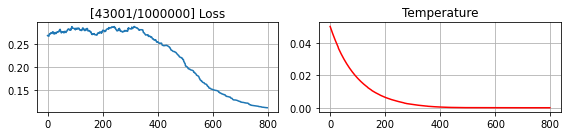


accepted: 799
{'total': 34270621696, 'available': 23250792448, 'percent': 32.2, 'used': 11019829248, 'free': 23250792448}
  43100/1000000[dt=7.98s, l=0.112]  43200/1000000[dt=7.58s, l=0.112]  43300/1000000[dt=7.70s, l=0.112]  43400/1000000[dt=7.58s, l=0.112]  43500/1000000[dt=7.83s, l=0.112]

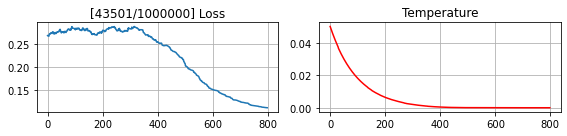


accepted: 799
{'total': 34270621696, 'available': 23259684864, 'percent': 32.1, 'used': 11010936832, 'free': 23259684864}
  43600/1000000[dt=8.12s, l=0.112]  43700/1000000[dt=7.77s, l=0.112]  43800/1000000[dt=7.66s, l=0.112]  43900/1000000[dt=7.74s, l=0.112]  44000/1000000[dt=7.69s, l=0.112]

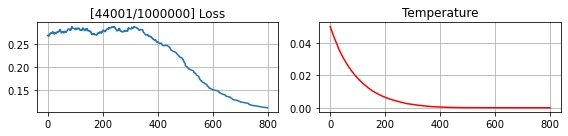


accepted: 800
{'total': 34270621696, 'available': 23266144256, 'percent': 32.1, 'used': 11004477440, 'free': 23266144256}
  44100/1000000[dt=8.08s, l=0.112]  44200/1000000[dt=7.69s, l=0.112]  44300/1000000[dt=7.74s, l=0.112]  44400/1000000[dt=7.62s, l=0.112]  44500/1000000[dt=7.65s, l=0.112]

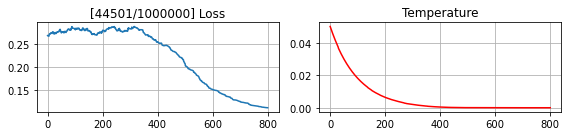


accepted: 801
{'total': 34270621696, 'available': 23263948800, 'percent': 32.1, 'used': 11006672896, 'free': 23263948800}
  44600/1000000[dt=8.00s, l=0.112]  44700/1000000[dt=7.78s, l=0.112]  44800/1000000[dt=7.63s, l=0.112]  44900/1000000[dt=7.74s, l=0.112]  45000/1000000[dt=7.77s, l=0.112]

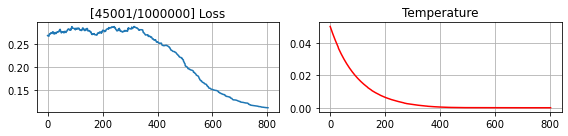


accepted: 803
{'total': 34270621696, 'available': 23264747520, 'percent': 32.1, 'used': 11005874176, 'free': 23264747520}
  45100/1000000[dt=7.86s, l=0.112]  45200/1000000[dt=7.74s, l=0.112]  45300/1000000[dt=7.77s, l=0.112]  45400/1000000[dt=7.64s, l=0.112]  45500/1000000[dt=7.74s, l=0.112]

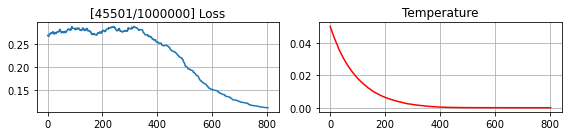


accepted: 804
{'total': 34270621696, 'available': 23266861056, 'percent': 32.1, 'used': 11003760640, 'free': 23266861056}
  45600/1000000[dt=8.00s, l=0.112]  45700/1000000[dt=8.57s, l=0.112]  45800/1000000[dt=8.40s, l=0.112]  45900/1000000[dt=8.35s, l=0.112]  46000/1000000[dt=8.36s, l=0.112]

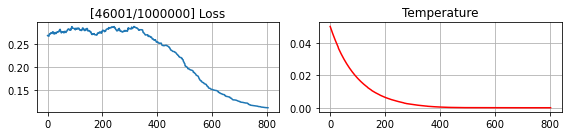


accepted: 804
{'total': 34270621696, 'available': 23009460224, 'percent': 32.9, 'used': 11261161472, 'free': 23009460224}
  46100/1000000[dt=8.49s, l=0.112]  46200/1000000[dt=8.12s, l=0.112]  46300/1000000[dt=7.97s, l=0.112]  46400/1000000[dt=8.02s, l=0.112]  46500/1000000[dt=7.98s, l=0.112]

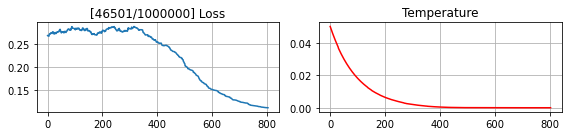


accepted: 804
{'total': 34270621696, 'available': 23174733824, 'percent': 32.4, 'used': 11095887872, 'free': 23174733824}
  46600/1000000[dt=8.14s, l=0.112]  46700/1000000[dt=8.17s, l=0.112]  46800/1000000[dt=8.69s, l=0.112]  46900/1000000[dt=8.38s, l=0.112]  47000/1000000[dt=7.97s, l=0.112]

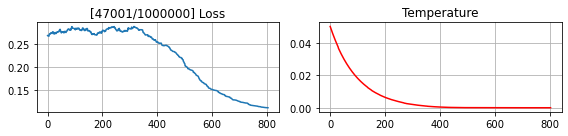


accepted: 804
{'total': 34270621696, 'available': 22667399168, 'percent': 33.9, 'used': 11603222528, 'free': 22667399168}
  47100/1000000[dt=8.06s, l=0.112]  47200/1000000[dt=7.76s, l=0.112]  47300/1000000[dt=8.03s, l=0.112]  47400/1000000[dt=8.05s, l=0.112]  47500/1000000[dt=7.97s, l=0.112]

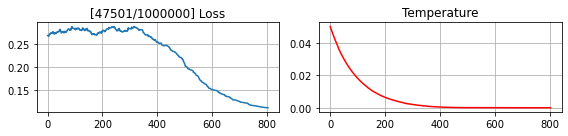


accepted: 804
{'total': 34270621696, 'available': 22681812992, 'percent': 33.8, 'used': 11588808704, 'free': 22681812992}
  47600/1000000[dt=8.16s, l=0.112]  47700/1000000[dt=7.83s, l=0.112]  47800/1000000[dt=8.04s, l=0.112]  47900/1000000[dt=8.07s, l=0.112]  48000/1000000[dt=7.88s, l=0.112]

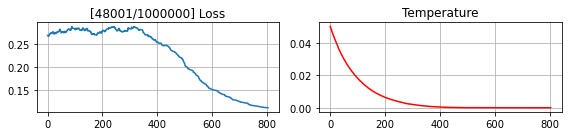


accepted: 804
{'total': 34270621696, 'available': 22729449472, 'percent': 33.7, 'used': 11541172224, 'free': 22729449472}
  48100/1000000[dt=8.00s, l=0.112]  48200/1000000[dt=8.06s, l=0.112]  48300/1000000[dt=7.97s, l=0.112]  48400/1000000[dt=8.43s, l=0.112]  48500/1000000[dt=8.36s, l=0.112]

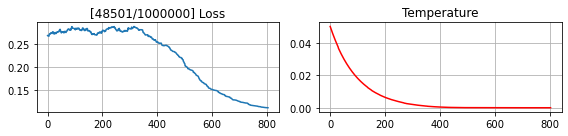


accepted: 804
{'total': 34270621696, 'available': 22594162688, 'percent': 34.1, 'used': 11676459008, 'free': 22594162688}
  48600/1000000[dt=8.12s, l=0.112]

KeyboardInterrupt: 

In [43]:
import math
def inside_elipsoid(p, a, b, c):
    is_inside = ((p[0]/a)**2 + (p[1]/b)**2 + (p[2]/c)**2 < 1.0)
    return is_inside
def uniform_rand(vmin, vmax):
    vrange = vmax - vmin
    choice = random.uniform(0,1)
    return vmin + vrange*choice
def uniform_rand_3d(vmins, vmaxs):
    x = uniform_rand(vmins[0], vmaxs[0])
    y = uniform_rand(vmins[1], vmaxs[1])
    z = uniform_rand(vmins[2], vmaxs[2])
    return np.array([x, y, z]).astype(np.float32)

class GaussianLayer(nn.Module):
    def __init__(self, device):
        super().__init__()
        self.device = device
        
        self.convs = {}
        kernel_size = 3
        sigma = 1
        self.convs[4] = self._get_gaussian_conv2d(kernel_size, sigma, channels=4)
        self.convs[3] = self._get_gaussian_conv2d(kernel_size, sigma, channels=3)
        self.convs[1] = self._get_gaussian_conv2d(kernel_size, sigma, channels=1)

        # Given groups=3, weight of size 3 1 3 3, expected input[1, 512, 512, 4] to have 3 channels, but got 512 channels instead
        
    def forward(self, x, kernel_size, sigma):
        if kernel_size < 3.0:
            return x

        channels = x.shape[-1]
        gaussian_kernel = self._generate_gaussian_kernel(kernel_size=kernel_size, sigma=sigma, channels=channels)
        self.convs[channels].weight.data = gaussian_kernel
        self.convs[channels].padding = int(kernel_size/2)
        
        x = x.transpose(3, 1)
        # gaussian_kernel: (channels, batch, w, h)=(4, 1, 3, 3)
        # x: (batch, channels, w, h)=(1, 4, 512, 512)
        out = self.convs[channels](x)
        out = out.transpose(3, 1)
        return out
    
    def _generate_gaussian_kernel(self, kernel_size, sigma, channels=4):
        # Create a x, y coordinate grid of shape (kernel_size, kernel_size, 2)
        x_cord = torch.arange(kernel_size)
        x_grid = x_cord.repeat(kernel_size).view(kernel_size, kernel_size)
        y_grid = x_grid.t()
        xy_grid = torch.stack([x_grid, y_grid], dim=-1)

        mean = (kernel_size - 1)/2.
        variance = sigma**2.

        # Calculate the 2-dimensional gaussian kernel which is
        # the product of two gaussian distributions for two different
        # variables (in this case called x and y)
        gaussian_kernel = (1./(2.*math.pi*variance)) * torch.exp(-torch.sum((xy_grid - mean)**2., dim=-1) / (2*variance + 1e-8))
        
#         gaussian_kernel = torch.sum((xy_grid - mean)**2, dim=-1)
        # Make sure sum of values in gaussian kernel equals 1.
        gaussian_kernel = gaussian_kernel / torch.sum(gaussian_kernel)
        # Reshape to 2d depthwise convolutional weight
        gaussian_kernel = gaussian_kernel.view(1, 1, kernel_size, kernel_size)
        gaussian_kernel = gaussian_kernel.repeat(channels, 1, 1, 1).to(self.device)
        return gaussian_kernel
    
    def _get_gaussian_conv2d(self, kernel_size, sigma, channels=4):
        gaussian_filter = nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=kernel_size, stride=1, padding=int(kernel_size/2), groups=channels, bias=False).to(self.device)
        gaussian_kernel = self._generate_gaussian_kernel(kernel_size=kernel_size, sigma=sigma, channels=channels)
        gaussian_filter.weight.data = gaussian_kernel
        gaussian_filter.weight.requires_grad = False
        return gaussian_filter
    
    
    
class Model(nn.Module):
    def __init__(self, device, **kwargs):
        super().__init__()
        
        self.device = device
        self.n_cams = kwargs.get('n_cams', None)
        self.cameras = None
        self.texture_maps = kwargs.get('texture_maps', None)
        self.mesh = kwargs.get('mesh', None)
        self.mesh_target = kwargs.get('mesh_target', None)
        self.target_images = None
        self.image_size = kwargs.get('image_size', None)
        self.batch_size = kwargs.get('batch_size', None)
        self.n_batch = int(self.n_cams / self.batch_size)
        self.camera_batches = []
        
        self.renderer, self.sil_renderer = self._init_renderer()
        self.target_image_batches, self.target_silhouette_batches = self._init_target_images()
        self.dverts = torch.from_numpy(np.zeros((self.mesh.verts_packed().shape), dtype=np.float32)).to(self.device)
        
        self.losses = {'all': [], 'pixel': [], 'silhouette': [], 'temperature': []}
        self.loss_best = {'all': 0.0, 'pixel': 0.0, 'silhouette': 0.0}
        self.images_accepted = []
        self.image_dict = None
        self.dverts_out = []
        
#         self.dverts = nn.Parameter(self.dverts, requires_grad=True)
#         self.center_offset = torch.from_numpy(np.zeros(3, dtype=np.float32)).to(self.device)
#         self.center_offset = nn.Parameter(self.center_offset, requires_grad=True)
        
#         self.gaussian = GaussianLayer(self.device)
        
#     def forward(self, batch_idx, kernel_size, sigma, raster_settings, blend_params):
#         # ==================================================================================== #
#         # minibatch training
#         i0 = batch_idx*self.batch_size
#         i1 = i0 + self.batch_size
        
#         # batch preparation
#         mesh_deformed = self.mesh.offset_verts(self.dverts)
#         meshes = mesh_deformed.extend(self.batch_size)
#         cam_batch = self.camera_batches[batch_idx]
        
#         # render
#         images = self.renderer(meshes_world=meshes, cameras=cam_batch, raster_settings=raster_settings, blend_params=blend_params)
#         silhouettes = self.sil_renderer(meshes_world=meshes, cameras=cam_batch, raster_settings=raster_settings, blend_params=blend_params)
        
#         target_images = self.target_image_batches[batch_idx]
#         target_silhouettes = self.target_silhouette_batches[batch_idx]
            
#         # losses
#         loss_pixels = torch.mean(torch.abs(images[..., :3] - target_images))
#         loss_silhouettes = 0.5*self._iou(silhouettes, target_silhouettes)
        
#         loss = loss_pixels + loss_silhouettes
#         loss_dict = {'all': loss, 'pixel': loss_pixels, 'silhouette': loss_silhouettes}
#         image_dict = {'images': images, 'silhouettes': silhouettes, 'target_images': target_images, 'target_silhouettes': target_silhouettes}
#         return image_dict, loss_dict

    def forward(self, batch_idx, raster_settings, blend_params, dverts=None):
        # ==================================================================================== #
        # minibatch training
        i0 = batch_idx*self.batch_size
        i1 = i0 + self.batch_size
        
        # batch preparation
        if dverts is None:
            meshes = self.mesh.extend(self.batch_size)
        else:
            mesh_deformed = self.mesh.offset_verts(dverts)
            meshes = mesh_deformed.extend(self.batch_size)
        cam_batch = self.camera_batches[batch_idx]
        
        # render
        images = self.renderer(meshes_world=meshes, cameras=cam_batch, raster_settings=raster_settings, blend_params=blend_params)
        #silhouettes = self.sil_renderer(meshes_world=meshes, cameras=cam_batch, raster_settings=raster_settings, blend_params=blend_params)
        #silhouettes = silhouettes[..., 3]
        silhouettes = images[..., 3]
        images = images[..., :3]
        return images.detach(), silhouettes.detach()
    
    def simulated_annealing(self, temperature_init, cooling_rate, iter_max, raster_settings, blend_params):
        vertices = self.mesh.verts_packed()
        normals = self.mesh.verts_normals_packed()
        n_vertices = len(self.mesh.verts_packed())
        n_batch = self.n_batch
        bath_size = self.batch_size
        image_size = self.image_size
        temperature = temperature_init
        radius = 0.1
        a = radius
        b = radius
        c = radius
        
        w_sil = 0.5
        w_pix = 1.0
        self.losses = {'all': [], 'pixel': [], 'silhouette': [], 'temperature': []}
        self.loss_best = {'all': 0.0, 'pixel': 0.0, 'silhouette': 0.0}
#         self.images_accepted = []
        self.image_dict = {'images': torch.empty(n_batch*batch_size, image_size, image_size, 3), 
                      'silhouettes': torch.empty(n_batch*batch_size, image_size, image_size),
                       'target_images': torch.empty(n_batch*batch_size, image_size, image_size, 3),
                       'target_silhouettes': torch.empty(n_batch*batch_size, image_size, image_size)}
        self.dverts_out = []
        t0 = time.time()
        for i in range(iter_max):
            # pick a random vertex
            v_idx = np.random.randint(0, n_vertices)
            
            # offset by random vector within sphere/elipsoid region
            while True:
                rand_offset = uniform_rand_3d([-a, -b, -c], [a, b, c])
                is_inside = inside_elipsoid(rand_offset, a, b, c)
                if is_inside:
                    break
            dverts_candidate = self.dverts.clone()
            dverts_candidate[v_idx] += torch.from_numpy(rand_offset).to(model.device)
            
            loss_cand = {'all': 0.0, 'pixel': 0.0, 'silhouette': 0.0}
            # see if dverts_candidate decreases loss
            image_dict_cand = {'images': torch.empty(n_batch*batch_size, image_size, image_size, 3), 
                               'silhouettes': torch.empty(n_batch*batch_size, image_size, image_size),
                               'target_images': torch.empty(n_batch*batch_size, image_size, image_size, 3),
                               'target_silhouettes': torch.empty(n_batch*batch_size, image_size, image_size)}
            for batch_idx in range(n_batch):
                i0 = batch_idx*batch_size
                i1 = i0 + batch_size
               
                # batch preparation
                mesh_deformed_cand = self.mesh.offset_verts(dverts_candidate)
                mesh_deformed_cand = mesh_deformed_cand.extend(batch_size)
                cam_batch = self.camera_batches[batch_idx]
                
                # render candidnate
                images_cand = self.renderer(meshes_world=mesh_deformed_cand, cameras=cam_batch, raster_settings=raster_settings, blend_params=blend_params)
                # silhouettes_cand = self.sil_renderer(meshes_world=mesh_deformed_cand, cameras=cam_batch, raster_settings=raster_settings, blend_params=blend_params)
                # silhouettes_cand = silhouettes_cand[..., 3]
                silhouettes_cand = images_cand[..., 3]
                images_cand = images_cand[..., :3]
                images_cand = images_cand.detach()
                silhouettes_cand = silhouettes_cand.detach()
                image_dict_cand['images'][i0:i1] = images_cand
                image_dict_cand['silhouettes'][i0:i1] = silhouettes_cand
                
                target_images = self.target_image_batches[batch_idx]
                target_silhouettes = self.target_silhouette_batches[batch_idx]
                
                if i == 0:
                    mesh_deformed_curr = self.mesh.offset_verts(self.dverts)
                    mesh_deformed_curr = mesh_deformed_curr.extend(batch_size)
                    images_curr = self.renderer(meshes_world=mesh_deformed_curr, cameras=cam_batch, raster_settings=raster_settings, blend_params=blend_params)
                    # silhouettes_curr = self.sil_renderer(meshes_world=mesh_deformed_curr, cameras=cam_batch, raster_settings=raster_settings, blend_params=blend_params)
                    # silhouettes_curr = silhouettes_curr[..., 3]
                    silhouettes_curr = images_curr[..., 3]
                    images_curr = images_curr[..., :3]
                    images_curr = images_curr.detach()
                    silhouettes_curr = silhouettes_curr.detach()
                    self.image_dict['images'][i0:i1] = images_curr
                    self.image_dict['silhouettes'][i0:i1] = silhouettes_curr

                    # losses
                    l_pix_curr = w_pix*torch.mean(torch.abs(images_curr - target_images))
                    l_sil_curr = w_sil*self._iou(silhouettes_curr, target_silhouettes)
                    l_pix_curr = l_pix_curr.detach()
                    l_sil_curr = l_sil_curr.detach()
                    
                    l_curr = l_pix_curr + l_sil_curr
                    self.loss_best['all'] += l_curr / n_batch
                    self.loss_best['pixel'] += l_pix_curr / n_batch
                    self.loss_best['silhouette'] += l_sil_curr / n_batch
                    
                l_pix_cand = w_pix*torch.mean(torch.abs(images_cand - target_images))
                l_sil_cand = w_sil*self._iou(silhouettes_cand, target_silhouettes)
                l_pix_cand = l_pix_cand.detach()
                l_sil_cand = l_sil_cand.detach()
                l_cand = l_pix_cand + l_sil_cand
                loss_cand['all'] += l_cand / n_batch
                loss_cand['pixel'] += l_pix_cand / n_batch
                loss_cand['silhouette'] += l_sil_cand / n_batch
                
            # compare the losses
            l_best = self.loss_best['all']
            l_cand = loss_cand['all']
            diff = (l_cand - l_best).data.detach().cpu()
            accept = False
            if diff < 0:
                # accept
                accept = True
            else:
                # accept according to Metropolis criteria
                if -diff / temperature < -600:
                    thres = 0
                else:
                    thres = np.exp(-diff / temperature)

                metro = random.uniform(0, 1)
                if thres > metro:
                    # accept
                    accept = True
                    
                    
            if accept:
                self.dverts_out.append(dverts_candidate.data.clone())
                self.dverts.data = dverts_candidate.data.clone()
                self.loss_best = loss_cand.copy()
                self.image_dict = image_dict_cand.copy()
#                 self.images_accepted.append(image_dict_cand['images'])
        
                self.losses['all'].append(self.loss_best['all'])
                self.losses['pixel'].append(self.loss_best['pixel'])
                self.losses['silhouette'].append(self.loss_best['silhouette'])
                self.losses['temperature'].append(temperature)
                
            # cool down
            temperature *= cooling_rate
            torch.cuda.empty_cache()
            
            if i % 100 == 0:
                t1 = time.time()
                print('  {}/{}[dt={:.2f}s, l={:.3f}]'.format(i, iter_max, t1-t0, self.losses['all'][-1]), end='')
                t0 = t1
                
                if i > 0 and i % 500 == 0:
                    fig, ax = plt.subplots(1, 2, figsize=(8, 2), tight_layout=True)
                    ax[0].plot(self.losses['all'])
                    ax[0].grid()
                    ax[0].set_title('[{}/{}] Loss'.format(i+1, iter_max))
                    ax[1].plot(self.losses['temperature'], c='r')
                    ax[1].grid()
                    ax[1].set_title('Temperature')
                    plt.show()
                    plt.close('all')
                    
                    cpu_percent = psutil.virtual_memory()._asdict()['percent']
                    print()
                    print('accepted: {}'.format(len(self.losses['all'])))
                    print(psutil.virtual_memory()._asdict())
                    
                    if cpu_percent > 95.0:
                        print('BREAK')
                        break
                    
#                 print(' {}/{}'.format(i, iter_max))
            
            
        for batch_idx in range(n_batch):
            i0 = batch_idx*batch_size
            i1 = i0 + batch_size
            self.image_dict['target_images'][i0:i1] = self.target_image_batches[batch_idx]
            self.image_dict['target_silhouettes'][i0:i1] = self.target_silhouette_batches[batch_idx]
        return self.image_dict, self.losses, {'dverts_out': self.dverts_out, 'images_accepted': self.images_accepted}
    
    
    def _iou(self, S1, S2):
        S1S2 = torch.mul(S1, S2)
        return torch.mean(1.0 - torch.sum(torch.abs(S1S2)) / torch.sum(torch.abs(S1+S2-S1S2)))
    
    def _init_target_images(self):
        meshes = self.mesh_target.extend(self.batch_size)
        
        target_image_batches = []
        target_sil_batches = []
        for batch_idx in range(self.n_batch):
            cam_batch = self.camera_batches[batch_idx]
            target_images = self.renderer(meshes_world=meshes, cameras=cam_batch)
            target_images = target_images[..., :3]
            target_image_batches.append(target_images)
        
            silhouette_images = self.sil_renderer(meshes_world=meshes, cameras=cam_batch)
            silhouette_images = silhouette_images[..., 3]
            target_sil_batches.append(silhouette_images)
            
        return target_image_batches, target_sil_batches
        
    def _init_cameras(self):
        d_angle = 360.0 / self.n_cams
        camera_batches = []
        for batch_idx in range(self.n_batch):
            i0 = batch_idx*self.batch_size
            i1 = i0 + self.batch_size
            
            R_batch = torch.empty([batch_size, 3, 3])
            T_batch = torch.empty([batch_size, 3])
            for i in range(self.batch_size):
                distance = 3
                elevation = 0.0
                azimuth = -150 + d_angle * (i0 + i)
                Ri, Ti = look_at_view_transform(distance, elevation, azimuth, device=self.device)
                R_batch[i] = Ri.squeeze()
                T_batch[i] = Ti.squeeze()
            cam_batch = OpenGLPerspectiveCameras(device=self.device, R=R_batch, T=T_batch)
            camera_batches.append(cam_batch)
        return camera_batches
            
    def _init_renderer(self):
        global image_size
        self.camera_batches = self._init_cameras()
        
        blend_params = BlendParams(sigma=1e-4, gamma=1e-4)
        raster_settings = RasterizationSettings(
            image_size=image_size, 
            blur_radius=0.0, #np.log(1. / 1e-4 - 1.) * blend_params.sigma, 
            faces_per_pixel=1, 
        )
        lights = PointLights(device=self.device, location=((2.0, 2.0, -2.0),)).to(self.device)
        a_diffuse = 0.0
        a_ambient = 0.9
        s = torch.from_numpy(np.zeros((1, 3)).astype(np.float32)).to(self.device)
        d = torch.from_numpy(np.ones((1, 3)).astype(np.float32)*a_diffuse).to(self.device)
        a = torch.from_numpy(np.ones((1, 3)).astype(np.float32)*a_ambient).to(self.device)
        lights.specular_color = s
        lights.diffuse_color = d
        lights.ambient_color = a
        
        rasterizer = MeshRasterizer(cameras=self.cameras, raster_settings=raster_settings)
        
        texture_renderer = MeshRenderer(
            rasterizer=rasterizer,
            shader=TexturedSoftPhongShader(device=self.device, cameras=None, blend_params=blend_params, lights=lights)
#             shader=SoftPhongShader(device=self.device, cameras=None, lights=lights, blend_params=blend_params)
        )
            
        silhouette_renderer = MeshRenderer(
            rasterizer=rasterizer,
            shader=SoftSilhouetteShader(blend_params=blend_params)
        )
        
        return texture_renderer, silhouette_renderer


n_cams = 16
batch_size = 8
model = Model(device=device, mesh=mesh, mesh_target=mesh_target, n_cams=n_cams, batch_size=batch_size, image_size=image_size, texture_maps=texture_map)

cooling_rate = 0.99
iter_max = 1000000
temperature_init = 0.05
blend_params = BlendParams(sigma=1e-4, gamma=1e-4)
raster_settings = RasterizationSettings(
        image_size=image_size, 
        blur_radius=0.0, #np.log(1. / 1e-4 - 1.) * blend_params.sigma, 
        faces_per_pixel=1, 
)
t0 = time.time()
image_dict, loss_dict, aux = model.simulated_annealing(temperature_init, cooling_rate, iter_max, raster_settings, blend_params)
t1 = time.time()
# ================== #
# for batch_idx in range(model.n_batch):
#     images, _ = model(batch_idx, raster_settings, blend_params, dverts=None)
#     images = images.cpu().numpy()
#     # images = model.target_silhouette_batches[batch_idx].squeeze().detach().cpu().numpy()
# #     images = model.target_image_batches[batch_idx].squeeze().detach().cpu().numpy()
#     for i in range(model.batch_size):
#         cam_idx = batch_idx*batch_size + i
#         plt.figure(figsize=(4, 4))
#         plt.title('Camera[{}]'.format(cam_idx))
#         plt.imshow(images[i])
#         plt.show()
# ================== #

# # ================== #
# # test run
# blend_params = BlendParams(sigma=1e-4, gamma=1e-4)
# raster_settings = RasterizationSettings(
#         image_size=image_size, 
#         blur_radius=0.0, #np.log(1. / 1e-4 - 1.) * blend_params.sigma, 
#         faces_per_pixel=1, 
# )

# lr = 0.001
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# losses = {'all': [], 'pixel': [], 'silhouette': []}
# kernel_size = 0
# sigma = 9

# optimizer.zero_grad()
# image_dict, loss_dict = model(batch_idx=0, kernel_size=kernel_size, sigma=sigma, raster_settings=raster_settings, blend_params=blend_params)
# for k, v in loss_dict.items():
#     vv = v.detach().cpu().numpy()
#     losses[k].append(vv)

# loss = loss_dict['all']
# image_dict['images'].retain_grad()
# loss.backward()
# optimizer.step()
# # ================== #

    
# out_dir = './7_data/output'
# out_path = out_dir + '/plot.png'

# images = image_dict['images']
# images_target = image_dict['target_images']
# cam_idx = 0
# plot_image = render_plots_simple(out_dir, 1, losses, 0.01, model.n_cams, cam_idx, images[cam_idx][..., :3], images_target[cam_idx], raster_settings=raster_settings, blend_params=blend_params)

# image_grad = image_dict['images'].grad
# grads = {'image': [0.1, 0.01, 0.001], 'vertex': [0.01, 0.001]}
# grads['vertex'].append(np.linalg.norm(model.dverts.grad.detach().cpu().numpy()))
# plot_grads = render_grads(out_dir, 1, losses, 0.01, model, grads, image_grad[cam_idx], raster_settings=raster_settings, blend_params=blend_params)

# plot_image = np.hstack([plot_image, np.ones((plot_grads.shape[0], plot_grads.shape[1]-plot_image.shape[1], plot_grads.shape[2]))])

# image = Image.fromarray(np.uint8(np.vstack([plot_image, plot_grads])))
# plt.figure(figsize=(22, 11))
# plt.imshow(image)
# plt.show()



# vertices = model.mesh.verts_packed().detach().cpu().numpy()
# normals = model.mesh.verts_normals_packed().detach().cpu().numpy()
# def draw_sphere(ax, radius):
#     u = np.linspace(0, np.pi, 60)
#     v = np.linspace(0, 2 * np.pi, 60)
#     x = radius*np.outer(np.sin(u), np.sin(v))
#     y = radius*np.outer(np.sin(u), np.cos(v))
#     z = radius*np.outer(np.cos(u), np.ones_like(v))
#     ax.plot_wireframe(x, y, z, color='k', linewidth=0.1)
    
# def inside_elipsoid(p, a, b, c):
#     is_inside = ((p[0]/a)**2 + (p[1]/b)**2 + (p[2]/c)**2 < 1.0)
#     return is_inside

# def uniform_rand(vmin, vmax):
#     vrange = vmax - vmin
#     choice = random.uniform(0,1)
#     return vmin + vrange*choice
# def uniform_rand_3d(vmins, vmaxs):
#     x = uniform_rand(vmins[0], vmaxs[0])
#     y = uniform_rand(vmins[1], vmaxs[1])
#     z = uniform_rand(vmins[2], vmaxs[2])
#     return np.array([x, y, z]).astype(np.float32)



# %matplotlib notebook
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(vertices[:, 0], vertices[:, 1], vertices[:, 2])
# for i in range(len(vertices)):
#     v0 = vertices[i]
#     v1 = v0 + normals[i]
#     ax.plot([v0[0], v1[0]], [v0[1], v1[1]], [v0[2], v1[2]], 'r')
# draw_sphere(ax, radius)
# ax.scatter(rand_point[0], rand_point[1], rand_point[2], c='m', s=5)
# # for _ in range(1):
# #     rand_point = uniform_rand_3d([-a, -b, -c], [a, b, c])
# #     is_inside = inside_elipsoid(rand_point, a, b, c)
# #     if is_inside:
# #         ax.scatter(rand_point[0], rand_point[1], rand_point[2], c='r', s=1)
# #     else:
# #         ax.scatter(rand_point[0], rand_point[1], rand_point[2], c='b', s=1)
# L = 2
# ax.set_xlim([-L, L])
# ax.set_ylim([-L, L])
# ax.set_zlim([-L, L])
# plt.show()


print('\nDone: {:.2f}s'.format(t1-t0))

In [ ]:
#!/usr/bin/env python
import psutil
# gives a single float value
psutil.cpu_percent()
# gives an object with many fields
psutil.virtual_memory()
# you can convert that object to a dictionary 
print(dict(psutil.virtual_memory()._asdict()))
print(psutil.virtual_memory()._asdict()['percent'])

In [50]:
image_dict = model.image_dict
loss_dict = model.losses
aux = {'dverts_out': model.dverts_out, 'images_accepted': model.images_accepted}
images_accepted = aux['images_accepted']

target_image_batches = model.target_image_batches.copy()
target_silhouette_batches = model.target_silhouette_batches.copy()

for i in range(len(target_image_batches)):
    target_image_batches[i] = target_image_batches[i]
    target_silhouette_batches[i] = target_silhouette_batches[i]
for k, v in image_dict.items():
    print(k, ':', v.shape)
for k, v in loss_dict.items():
    print(k, ':', len(v))

images : torch.Size([16, 128, 128, 3])
silhouettes : torch.Size([16, 128, 128])
target_images : torch.Size([16, 128, 128, 3])
target_silhouettes : torch.Size([16, 128, 128])
all : 804
pixel : 804
silhouette : 804
temperature : 804


In [51]:
target_images = np.vstack([target_image_batches[0].detach().cpu().numpy(), target_image_batches[1].detach().cpu().numpy()])
target_silhouettes = np.vstack([target_silhouette_batches[0].detach().cpu().numpy(), target_silhouette_batches[1].detach().cpu().numpy()])
print(target_images.shape, target_silhouettes.shape)

(16, 128, 128, 3) (16, 128, 128)


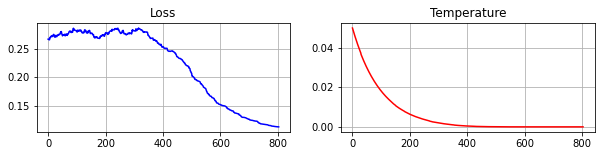

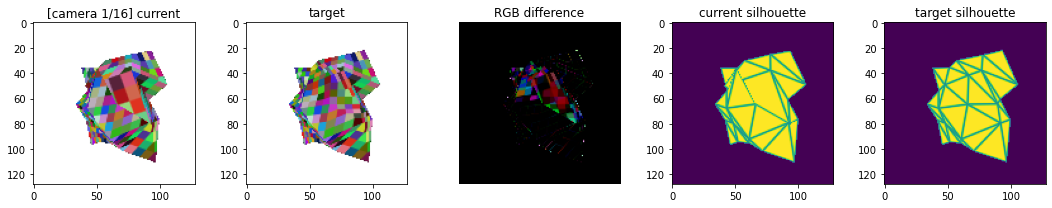

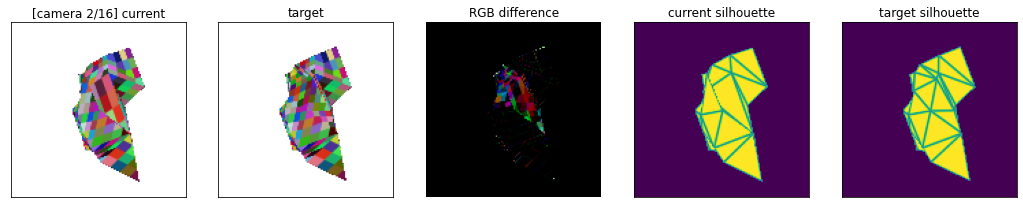

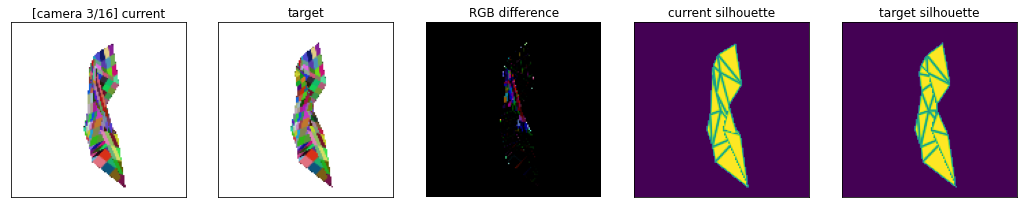

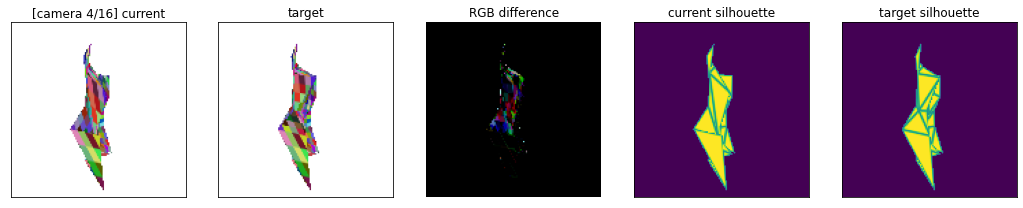

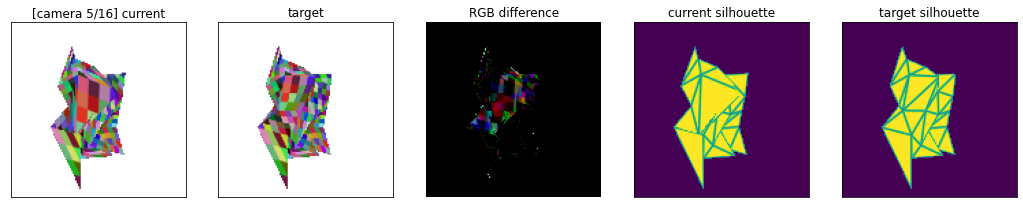

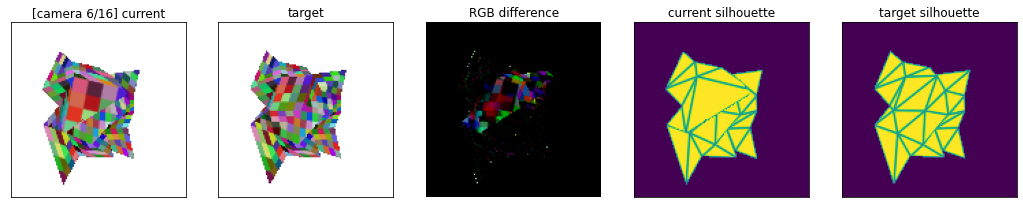

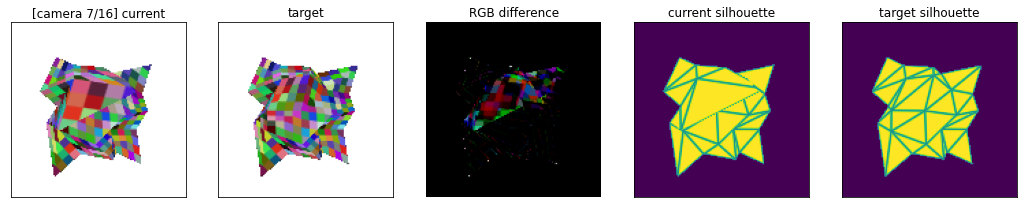

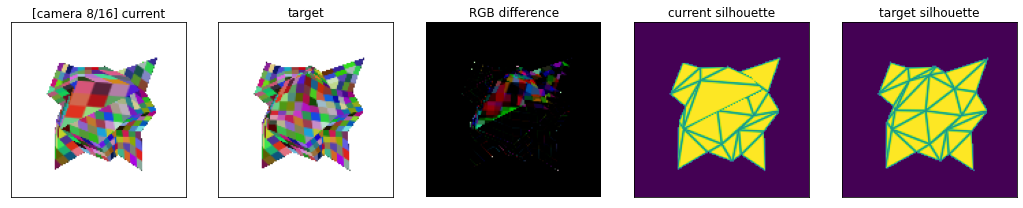

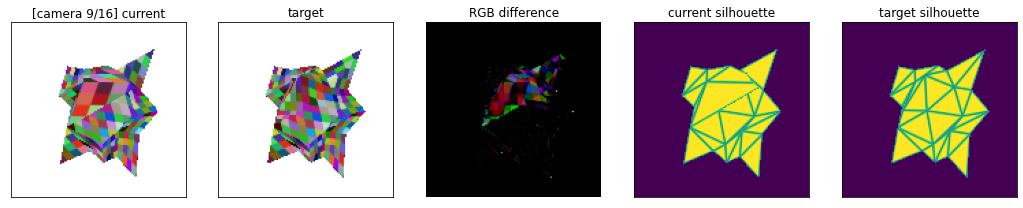

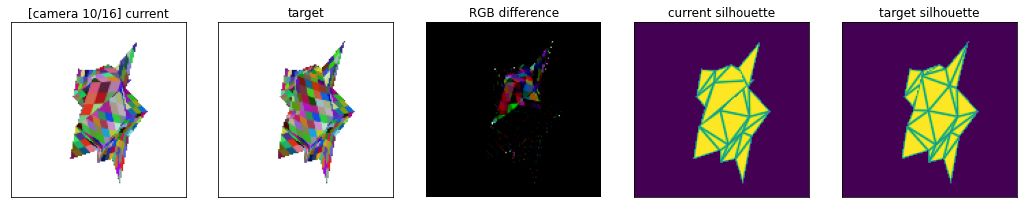

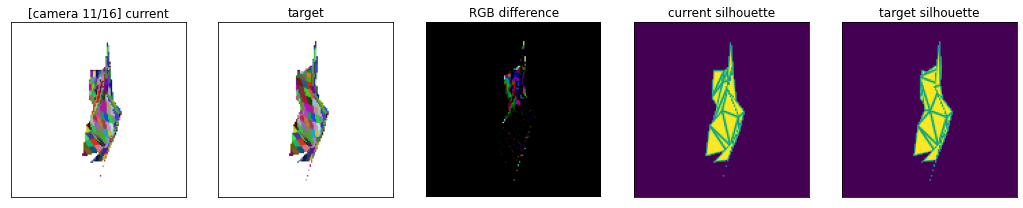

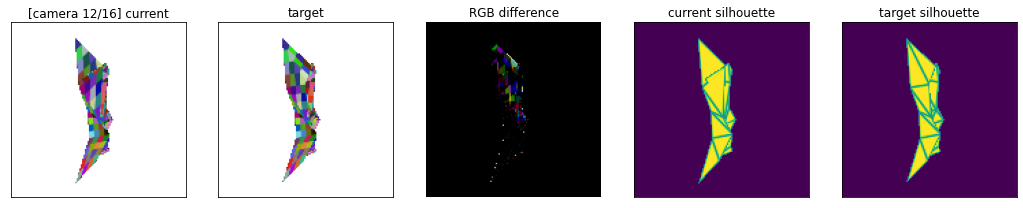

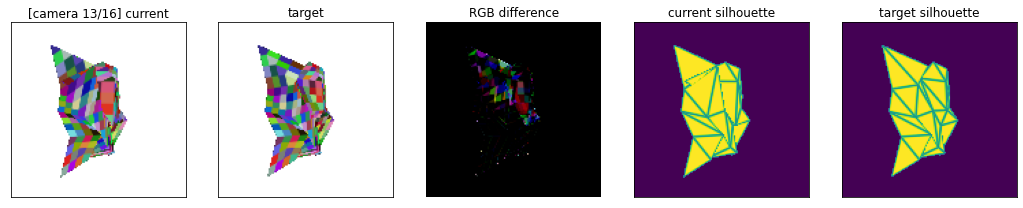

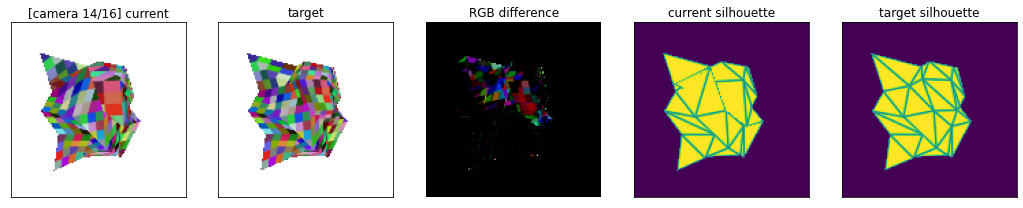

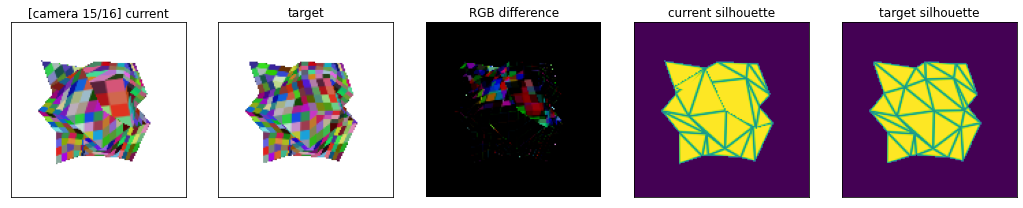

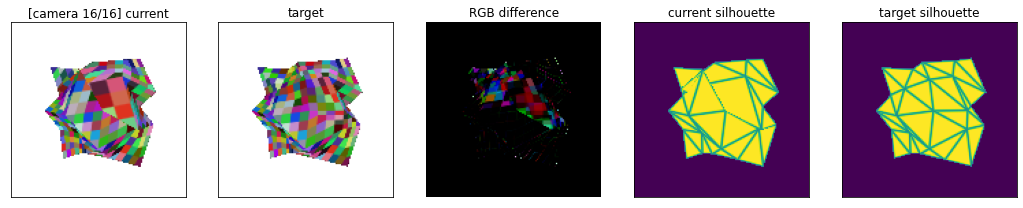

Done: 7.75s


In [52]:
t0 = time.time()


out_dir = './7_data/output'
fig, ax = plt.subplots(1, 2, figsize=(10, 2))
ax[0].plot(loss_dict['all'], c='b')
ax[0].grid()
ax[0].set_title('Loss')
ax[1].plot(loss_dict['temperature'], c='r')
ax[1].set_title('Temperature')
ax[1].grid()
plt.savefig(out_dir + '/final_loss.png', dpi=300)
plt.show() 

images = image_dict['images'].cpu().numpy()
silhouettes = image_dict['silhouettes'].cpu().numpy()
images_target = image_dict['target_images'].cpu().numpy()
silhouettes_target = image_dict['target_silhouettes'].cpu().numpy()

for cam_idx in range(n_cams):
    fig, ax = plt.subplots(1, 5, figsize=(15, 3), tight_layout=True)
    ax[0].imshow(images[cam_idx])
    ax[0].set_title('[camera {}/{}] current'.format(cam_idx+1, images.shape[0]))
    ax[1].imshow(target_images[cam_idx])
    ax[1].set_title('target')
    diff = images[cam_idx] - target_images[cam_idx]
    diff = np.clip(diff, a_min=0.0, a_max=1.0)
    ax[2].imshow(diff)
    ax[2].set_title('RGB difference')
    ax[2].axis('off')
    
    ax[3].imshow(silhouettes[cam_idx])
    ax[3].set_title('current silhouette')
    
    ax[4].imshow(target_silhouettes[cam_idx])
    ax[4].set_title('target silhouette')
    if cam_idx > 0:
        ax[0].set_xticks([])
        ax[0].set_yticks([])
        ax[1].set_xticks([])
        ax[1].set_yticks([])
        ax[3].set_xticks([])
        ax[3].set_yticks([])
        ax[4].set_xticks([])
        ax[4].set_yticks([])
    plt.savefig(out_dir + '/final_cam{}.png'.format(cam_idx), dpi=300)
    plt.show()
    plt.close('all')
print('Done: {:.2f}s'.format(time.time()-t0))

In [ ]:
images_accepted = aux['images_accepted']
dverts = aux['dverts_out']
losses = loss_dict['all']
n_batch = model.n_batch
batch_size = model.batch_size
image_size = model.image_size
n_cams = model.n_cams

target_images = np.empty((n_batch*batch_size, image_size, image_size, 3))
for batch_idx in range(n_batch):
    i0 = batch_idx*batch_size
    i1 = i0 + batch_size
    
    target_imgs = model.target_image_batches[batch_idx]
    target_imgs = target_imgs.detach().cpu().numpy()
    target_images[i0:i1] = target_imgs

cam_idx = 0

dv_norms = []
out_dir = './7_data/output'
out_path = out_dir + '/plot.png'
gif_path = out_dir + '/plots.gif'
gif_images = []
for i in range(len(images_accepted)):
    if i % 100 != 0:
        continue
    if i % 10 == 0:
        print(' {}/{}'.format(i, len(images_accepted)))
        if i > 0 and i % 100 == 0:
            print()
    images = images_accepted[i].detach().cpu().numpy()
    img = images[cam_idx]
    img_target = target_images[cam_idx]
    
    dv = dverts[i].detach().cpu().numpy()
    dv_norm = np.linalg.norm(dv)
    dv_norms.append(dv_norm)
    
    fig, ax = plt.subplots(1, 5, figsize=(20, 4), tight_layout=0)
    ax[0].plot(losses[0:i+1])
    ax[0].set_title('Total loss')
    ax[0].grid()
    
    ax[1].plot(dv_norms)
    ax[1].set_title('||dverts||')
    ax[1].grid()
    
    ax[2].imshow(img)
    ax[2].set_title('current | cam[{}/{}]'.format(cam_idx + 1, n_cams))
    ax[3].imshow(img_target)
    ax[3].set_title('target')
    
    diff = np.clip(img_target-img, a_min=0, a_max=1.0)
    ax[4].imshow(diff)
    ax[4].set_title('difference')
    plt.suptitle('Frame: {}/{}'.format(i+1, len(images_accepted)))
    plt.savefig(out_path, dpi=150)
    plt.close('all')
    
    img = imageio.imread(out_path)
    img_gif = Image.fromarray(np.uint8(img))
    gif_images.append(img_gif)
#     cam_idx += 1
#     if cam_idx >= n_cams:
#         cam_idx = 0

gif_images[0].save(gif_path, save_all=True, append_images=gif_images[1:], optimize=False, duration=10, loop=0)
print('gif saved:', gif_path)

In [ ]:
torch.cuda.empty_cache()
bytes_reserved = torch.cuda.memory_reserved()
print('torch.cuda.memory_reserved(): {:,.2f} Mb'.format(bytes_reserved * 0.000001))
bytes_alloc = torch.cuda.memory_allocated()
print('torch.cuda.memory_allocated(): {:,.2f} Mb'.format(bytes_alloc * 0.000001))
bytes_cached = torch.cuda.memory_cached()
print('torch.cuda.memory_cached(): {:,.2f} Mb'.format(bytes_cached * 0.000001))

In [ ]:
%matplotlib inline
from torch.optim.lr_scheduler import ReduceLROnPlateau
out_dir = './7_data/output'
gif_path = out_dir + '/plots.gif'
out_path = out_dir + '/plot.png'
n_cams = 20
batch_size = 10
model = Model(device=device, mesh=mesh, mesh_target=mesh_target, n_cams=n_cams, batch_size=batch_size, texture_maps=texture_map)
texture_map = model.mesh.textures._maps_padded.clone()

now = datetime.now()
hour = str(now.hour)
minute = str(now.minute)
date_str = '{}{:>02}{:>02}'.format(now.year, now.month, now.day)
log_path = out_dir + '/log_{}.txt'.format(date_str)
__output_log(log_path, '========== {} Start ==========================\n'.format(date_str))
print('Log output: {}'.format(log_path))



lr = 0.001
gauss_kernel_size = 0
gauss_sigma = 64
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# optimize = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
loop = tqdm_notebook(range(1000000000))

cam_idx = 0
images = []
losses = {'all': [], 'pixel': [], 'silhouette': []}
grads = {'vertex': []}
latest_states = {}
sigma = 1e-4

for e in loop:
    t0 = time.time()
    show_image = (e % 2 == 0)
    lr_curr = optimizer.param_groups[0]['lr']

    optimizer.zero_grad()
    
    if e > 0 and e % 50 == 0:
        sigma = max(1e-4, sigma*0.5)
        gauss_kernel_size = max(0, int(gauss_kernel_size*0.5))
        gauss_sigma = max(1.0, gauss_sigma*0.5)
        if gauss_kernel_size % 2 == 0:
            gauss_kernel_size += 1
        
    blend_params = BlendParams(sigma=sigma, gamma=1e-4)
    raster_settings = RasterizationSettings(
                image_size=image_size, 
                blur_radius=np.log(1. / 1e-4 - 1.) * blend_params.sigma, 
                faces_per_pixel=1, 
    )
    
    
    loss_dict = {'all': 0.0, 'pixel': 0.0, 'silhouette': 0.0}
    image_dict = {'images': torch.empty(model.n_batch*model.batch_size, image_size, image_size, 4), 
                  'silhouettes': torch.empty(model.n_batch*model.batch_size, image_size, image_size), 
                  'target_images': torch.empty(model.n_batch*model.batch_size, image_size, image_size, 3), 
                  'target_silhouettes': torch.empty(model.n_batch*model.batch_size, image_size, image_size)}
    
    for batch_idx in range(model.n_batch):
        img_dict, l_dict = model(batch_idx=batch_idx, kernel_size=gauss_kernel_size, sigma=gauss_sigma, raster_settings=raster_settings, blend_params=blend_params)
        loss = l_dict['all']
        loss_pixel = l_dict['pixel']
        loss_sil = l_dict['silhouette']
        loss.backward()
        optimizer.step()
        
        loss_dict['all'] += loss.data / model.n_batch
        loss_dict['pixel'] += loss_pixel / model.n_batch
        loss_dict['silhouette'] += loss_sil / model.n_batch
    
        i0 = batch_idx*model.batch_size
        i1 = i0 + model.batch_size
        image_dict['images'][i0:i1] = img_dict['images']
        image_dict['silhouettes'][i0:i1] = img_dict['silhouettes']
        image_dict['target_images'][i0:i1] = img_dict['target_images']
        image_dict['target_silhouettes'][i0:i1] = img_dict['target_silhouettes']
        
    loop.set_description('[{}/{}] loss({:.4f}, {:.4f}, {:.4f})'.format(e+1, len(loop), loss_dict['all'], loss_dict['pixel'], loss_dict['silhouette']))
    losses['all'].append(loss_dict['all'])
    losses['pixel'].append(loss_dict['pixel'])
    losses['silhouette'].append(loss_dict['silhouette'])
    
    t1 = time.time()
    mb_alloc = torch.cuda.memory_allocated() * 0.000001
    mb_cached = torch.cuda.memory_cached() * 0.000001
    now = datetime.now()
    hour = str(now.hour)
    minute = str(now.minute)
    second = str(now.second)
    now_str = '{:>02}:{:>02}:{:>02}'.format(hour, minute, second)
    __output_log(log_path, '{} | {:03} | {:.2f}s | lr={:.8f} | loss(all={:.6f}, pixel={:.6f}, sil={:.6f} | GPU_allocated({:,.2f}Mb) | GPU_cached({:,.2f}Mb)\n'.format(now_str, e+1, t1-t0, lr, loss_dict['all'], loss_dict['pixel'], loss_dict['silhouette'], mb_alloc, mb_cached))
        
    if show_image:
        image = image_dict['images'][cam_idx, ..., :3]
        image_target = image_dict['target_images'][cam_idx]
        grads['vertex'].append(np.linalg.norm(model.dverts.grad.detach().cpu().numpy()))
        
        plot_image = render_plots_simple(out_dir, e, losses, lr, model.n_cams, cam_idx, image, image_target, raster_settings=raster_settings, blend_params=blend_params)
        plot_grads = render_grads(out_dir, e, losses, lr, model, grads, image_grad, raster_settings=raster_settings, blend_params=blend_params)
#         plot_grads = np.zeros(plot_image.shape)
        if plot_grads.shape[1]-plot_image.shape[1] > 0:
            plot_image = np.hstack([plot_image, np.ones((plot_grads.shape[0], plot_grads.shape[1]-plot_image.shape[1], plot_grads.shape[2]))])
        else:
            plot_grads = np.hstack([plot_grads, np.ones((plot_image.shape[0], plot_image.shape[1]-plot_grads.shape[1], plot_image.shape[2]))])
        gif_out = np.vstack([plot_image, plot_grads])
        gif_out_pil = Image.fromarray(np.uint8(gif_out))
        images.append(gif_out_pil)
        images[0].save(gif_path, save_all=True, append_images=images[1:], optimize=False, duration=250, loop=0)
        
        plt.figure(figsize=(15, 6))
        plt.gca().grid('off')
        plt.gca().axis('off')
        plt.imshow(images[-1], vmin=0, vmax=255)
        out_path = out_dir + '/plot_{}.png'.format(e)
        plt.savefig(out_path, dpi=300)
        plt.show()
        plt.close('all')
        
        cam_idx += 1
        if cam_idx >= model.n_cams:
            cam_idx
    scheduler.step(loss)
    if lr_curr < 2e-8:
        print('lr={}. BREAK'.format(lr_curr))
        break
    if e > 200:
        print('e={}. BREAK'.format(e))
        break
images[0].save(gif_path, save_all=True, append_images=images[1:], optimize=False, duration=300, loop=0)
print('gif saved:', gif_path)

In [ ]:

def render_plots(out_dir, e, losses, lr, image_curr, target_image, texture_map, model, raster_settings, blend_params):
    fig, ax = plt.subplots(1, 6, figsize=(24, 4), tight_layout=True)
    ax[5].grid('off')
    ax[5].axis('off')
    loss_all = losses['all']
    loss_pixel = losses['pixel']
    loss_silhouette = losses['silhouette']
    ax[0].plot(loss_all, linewidth=4)
    ax[0].plot(loss_pixel)
    ax[0].plot(loss_silhouette)
    ax[0].legend(['all', 'pixel', 'silhouette'])
    ax[0].set_title('Losses\nlr={:.6f}\n{:.4f} | {:.4f} | {:.4f}'.format(lr, loss_all[-1], loss_pixel[-1], loss_silhouette[-1]))
    ax[0].set_ylim(bottom=0)
    ax[0].grid()
    
    sigma = blend_params.sigma
    gamma = blend_params.gamma
    blur_radius = raster_settings.blur_radius
    img_np = image_curr.detach().squeeze().cpu().numpy()
    img_cur = img_np[..., :3]
    ax[1].imshow(img_np, cmap='gray')
    ax[1].set_title('Current\n{:<13}:{:.4f}\n{:<13}:{:.4f}\n{:<13}:{:.4f}'.format('sigma', sigma, 'gamma', gamma, 'blur_radius', blur_radius))
    
    img_tar = target_image.detach().squeeze().cpu().numpy()
    ax[2].imshow(img_tar, cmap='gray')
    ax[2].set_title('Target')
    
    diff = np.clip(img_tar - img_cur, a_min=0.0, a_max=1.0)
    ax[3].imshow(diff)
    ax[3].set_title('Difference')
    
    ax[4].imshow(texture_map.detach().squeeze().cpu().numpy(), cmap='gray')
    ax[4].set_title('Texturemap')

    ax[5] = fig.add_subplot(166, projection='3d')
    # image gradient
#     grad = image_curr.grad.detach().cpu().numpy()
#     print(grad)
    # vertex gradient
    dverts = model.dverts.grad.detach().cpu().numpy()
    dverts_norm = np.linalg.norm(dverts)
    verts = model.mesh.verts_packed().detach().cpu().numpy()
    ax[5].set_title('gradients: {:.3f}'.format(dverts_norm))
    ax[5].quiver(verts[:,0], verts[:,1], verts[:,2], dverts[:,0], dverts[:,1], dverts[:,2], length=5, lw=2, arrow_length_ratio=0.1, color='r')
    ax[5].view_init(elev=-90, azim=0)
    L = 0.75
    ax[5].set_xlim([-L, L])
    ax[5].set_ylim([-L, L])
    ax[5].set_zlim([-L, L])
    plt.suptitle('Epoch={}'.format(e))
    
    out_path = out_dir + '/plot_{}.png'.format(e)
    plt.savefig(out_path, dpi=300)
    plot_image = imageio.imread(out_path)
    plt.close('all')
    
    return plot_image

def render_plots_simple(out_dir, e, losses, lr, n_cams, cam_idx, image_curr, target_image, raster_settings, blend_params):
    fig, ax = plt.subplots(1, 4, figsize=(16, 4), tight_layout=True)
    loss_all = losses['all']
    loss_pixel = losses['pixel']
    loss_silhouette = losses['silhouette']
    ax[0].plot(loss_all, linewidth=4)
    ax[0].plot(loss_pixel)
    ax[0].plot(loss_silhouette)
    ax[0].legend(['all', 'pixel', 'silhouette'])
    ax[0].set_title('Losses\nlr:{:.6f}, loss:{:.4f}|px:{:.2f}|sil:{:.2f}|'.format(lr, loss_all[-1], loss_pixel[-1], loss_silhouette[-1]))
    ax[0].set_ylim(bottom=0)
    ax[0].grid()
    
    sigma = blend_params.sigma
    gamma = blend_params.gamma
    blur_radius = raster_settings.blur_radius
    img_np = image_curr.detach().squeeze().cpu().numpy()
    if len(img_np.shape) > 2:
        img_cur = img_np[..., :3]
    else:
        img_cur = img_np
    ax[1].imshow(img_np, cmap='gray')
    ax[1].set_title('current (camera={}/{})'.format(cam_idx+1, n_cams))
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    ax[1].set_xlabel('{}:{:.4f} | {}:{:.4f} | {}:{:.4f}'.format('sigma', sigma, 'gamma', gamma, 'blur_radius', blur_radius))
    img_tar = target_image.detach().squeeze().cpu().numpy()
    ax[2].imshow(img_tar, cmap='gray')
    ax[2].set_title('target')
    ax[2].set_xticks([])
    ax[2].set_yticks([])
    diff = np.clip(np.abs(img_tar - img_cur), a_min=0.0, a_max=1.0)
    ax[3].imshow(diff)
    ax[3].set_title('difference')
    
    plt.suptitle('Epoch={}'.format(e))
    out_path = out_dir + '/plot.png'
    plt.savefig(out_path, dpi=300)
    plot_image = imageio.imread(out_path)
    plt.close('all')
    
    return plot_image

def render_grads(out_dir, e, losses, lr, model, grads, image_grad, raster_settings, blend_params):
    keys = list(grads.keys())
    n_grads = len(keys)
    offset_i = 2
    fig, ax = plt.subplots(1, offset_i+n_grads, figsize=((offset_i+n_grads)*4, 4), tight_layout=True)
    
    loss_all = losses['all']
    loss_pixel = losses['pixel']
    loss_silhouette = losses['silhouette']
    
    ax[1] = fig.add_subplot(1, (offset_i+n_grads), offset_i, projection='3d')
    dverts_grad = model.dverts.grad.detach().cpu().numpy()
    dverts_norm = np.linalg.norm(dverts_grad)
    dverts = dverts_grad / dverts_norm * 0.08
    verts = model.mesh.verts_packed().detach().cpu().numpy()
    ax[1].set_title('vertex 3d gradients: {:.3f}'.format(dverts_norm))
    ax[1].quiver(verts[:,0], verts[:,1], verts[:,2], dverts[:,0], dverts[:,1], dverts[:,2], length=5, lw=2, arrow_length_ratio=0.1, color='r')
    ax[1].scatter(verts[:,0], verts[:,1], verts[:,2], c='k', s=0.1)
    ax[1].view_init(elev=-90, azim=90)
    L = 1.2
    ax[1].set_xlim([-L, L])
    ax[1].set_ylim([-L, L])
    ax[1].set_zlim([-L, L])
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    
    image_grad = image_grad.detach().squeeze().cpu().numpy()
    max_0 = np.max(image_grad, axis=0)
    max_1 = np.max(max_0, axis=0)
    min_0 = np.min(image_grad, axis=0)
    min_1 = np.min(min_0, axis=0)
    vmin = np.min(image_grad)
    vmax = np.max(image_grad)
#     ax[2].imshow(image_grad, vmin=vmin, vmax=vmax)
#     ax[2].set_title('min={:.3f}, max={:.3f}'.format(vmin, vmax))
    
    legends = []
    for i in range(offset_i, n_grads + offset_i):
        legends.append(keys[i-offset_i])
        vals = grads[keys[i-offset_i]]
        ax[0].plot(vals)
#         ax[i].plot(vals)
#         ax[i].set_title('gradients mag ({}): {:.6f}'.format(keys[i-offset_i], vals[-1]))
#         ax[i].grid()
        ax[i].axis('off')
    ax[0].legend(legends)
    ax[0].set_title('Gradient magnitudes')
    ax[0].grid()
    
    plt.suptitle('<Gradients>')
    out_path = out_dir + '/plot.png'
    plt.savefig(out_path, dpi=300)
    plot_image = imageio.imread(out_path)
    plt.close('all')
    
    return plot_image 